In [1]:
import splitfolders
import shutil
import os
from PIL import Image
import glob
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array
import tensorflow as tf
from sklearn.utils.class_weight import compute_class_weight
import keras_tuner as kt
import tensorflow_hub as hub

### Build Train/Test/Validation datasets from the given dataset

In [111]:
import os

os.chdir("/Users/madhurimakhirbat/Documents/GitHub/untitled folder/Traffic_Sign_Detection")

def find_duplicates(folder):
    # Dictionary to store file hashes
    file_hashes = {}

    # List to store duplicate files
    duplicates = []

    # Walk through the directory and subdirectories
    for root, dirs, files in os.walk(folder):
        for filename in files:
            filepath = os.path.join(root, filename)
            # Calculate hash of each file
            with open(filepath, 'rb') as f:
                file_hash = hash(f.read())
            # Check if hash already exists
            if file_hash in file_hashes:
                duplicates.append((file_hashes[file_hash], filepath))
            else:
                file_hashes[file_hash] = filepath

    return duplicates

def check_duplicates_in_folders(folders):
    duplicates = []
    for folder in folders:
        folder_duplicates = find_duplicates(folder)
        duplicates.extend(folder_duplicates)

    return duplicates

train_folder = 'Dataset/train_test_val/train'
val_folder = 'Dataset/train_test_val/val'
test_folder = 'Dataset/train_test_val/test'
folders = [train_folder, val_folder, test_folder]

all_duplicates = check_duplicates_in_folders(folders)
if all_duplicates:
    print("Duplicates found:")
    for duplicate_pair in all_duplicates:
        print(duplicate_pair)
else:
    print("No duplicates found.")


Duplicates found:
('Dataset/train_test_val/train/round/bicycle/00686_00000.png', 'Dataset/train_test_val/train/round/bicycle/00714_00001.png')


In [3]:
def build_directory_dict(root_dir):
    directory_dict = {}

    for dirpath, dirnames, filenames in os.walk(root_dir):
        if dirpath != root_dir:
            parent_dir = os.path.basename(dirpath)
            if parent_dir not in directory_dict:
                directory_dict[parent_dir] = []
            for dirname in dirnames:
                directory_dict[parent_dir].append(dirname)

    # check if values for any key is empty then remove that key value pair from dict
    dict_copy = directory_dict.copy()
    print(dict_copy)
    for key, value in dict_copy.items():
        if not value:
            del directory_dict[key]
    return directory_dict

In [4]:
def copy_data_to_dest(source, dest, class_labels, split_ratios):

    for shape, types in class_labels.items():
        src = source + '/' + shape
        temp_dir = source + '/temp/' + shape

        if (os.path.exists(temp_dir)):
            shutil.rmtree(temp_dir) 

        splitfolders.ratio(src, output=temp_dir, ratio=split_ratios, seed=1337)
      
        for type_val in types:
            shutil.move(temp_dir + '/train/' + type_val, dest + '/train/' + shape + '/' + type_val)
            shutil.move(temp_dir + '/test/'  + type_val, dest + '/test/' + shape + '/' + type_val)
            shutil.move(temp_dir + '/val/'   + type_val, dest + '/val/' + shape + '/' + type_val)
        
    shutil.rmtree(r'./Dataset/trafficsigns_dataset/temp')

In [5]:
# use split folders to split the dataset into train, test and validation datasets
def create_train_test_val(split_ratios, src, dest):
    if (os.path.exists(dest)):
        shutil.rmtree(r'./Dataset/train_test_val') 
    splitfolders.ratio(src, output=dest, seed=1337, ratio=split_ratios)
    class_labels = build_directory_dict(src)
    copy_data_to_dest(src, dest, class_labels, split_ratios)
    
    

In [6]:
create_train_test_val(split_ratios=(0.6, 0.2, 0.2), src='Dataset/trafficsigns_dataset', dest='Dataset/train_test_val')  

Copying files: 0 files [00:00, ? files/s]


{'diamond': ['rightofway'], 'rightofway': [], 'hex': ['stop'], 'stop': [], 'square': ['laneend', 'parking', 'continue', 'crossing'], 'laneend': [], 'parking': [], 'continue': [], 'crossing': [], 'triangle': ['giveway', 'warning'], 'giveway': [], 'warning': [], 'round': ['traveldirection', 'limitedtraffic', 'speed', 'roundabout', 'noentry', 'noparking', 'bicycle', 'trafficdirective'], 'traveldirection': [], 'limitedtraffic': [], 'speed': [], 'roundabout': [], 'noentry': [], 'noparking': [], 'bicycle': [], 'trafficdirective': []}


Copying files: 282 files [00:00, 3729.50 files/s]
Copying files: 43 files [00:00, 3656.83 files/s]
Copying files: 688 files [00:00, 3920.16 files/s]
Copying files: 926 files [00:00, 3359.24 files/s]
Copying files: 1760 files [00:00, 3942.05 files/s]


### Fetch the images from the folder and build a dataframe

In [7]:
def build_df_from_image_list(image_list):
    df = pd.DataFrame(image_list, columns = ['Path', 'Shape', 'Type'])
    return df

In [180]:
def fetch_images(root_path):
    image_list = []
    # Define the list of allowed extensions
    allowed_extensions = ['jpg', 'jpeg', 'png', 'webp']
    # Construct the glob pattern to include all these extensions
    glob_pattern = f"{root_path}/*/*/*.*"  # This pattern will match all files in the specified directories with any extension
    
    for filepath in glob.glob(glob_pattern, recursive=True):
        # Check if the file has one of the allowed extensions
        if filepath.lower().split('.')[-1] in allowed_extensions:
            shape = filepath.split('/')[-3]  # Adjust indexing based on your directory structure
            types = filepath.split('/')[-2]  # Adjust indexing based on your directory structure
            image_list.append((filepath, shape, types))
    
    df = build_df_from_image_list(image_list)
    return df

In [9]:
train = fetch_images('Dataset/train_test_val/train/*/*/*.png')
test = fetch_images('Dataset/train_test_val/test/*/*/*.png')
val = fetch_images('Dataset/train_test_val/val/*/*/*.png')

In [11]:
train.head()

Path    Shape        Type
0  Dataset/train_test_val/train/diamond/rightofwa...  diamond  rightofway
1  Dataset/train_test_val/train/diamond/rightofwa...  diamond  rightofway
2  Dataset/train_test_val/train/diamond/rightofwa...  diamond  rightofway
3  Dataset/train_test_val/train/diamond/rightofwa...  diamond  rightofway
4  Dataset/train_test_val/train/diamond/rightofwa...  diamond  rightofway

In [12]:
def print_data_info(train, test, val, key='Shape'):
    print("########################## Shape ##########################")
    print(f" Train: {train.shape}, Test: {test.shape}, Val: {val.shape}\n",)
    print("########################## Unique ##########################")
    print("Total Classes: ", len(train[key].unique()))
    print(f" Train: {train[key].unique()}, \nTest: {test[key].unique()}, \nVal: {val[key].unique()}\n")
    print("########################## Count ##########################")
    print(f" Train: {train[key].value_counts()}, Test: {test[key].value_counts()}, Val: {val[key].value_counts()}\n")


In [13]:
print_data_info(train, test, val, key='Shape')

########################## Shape ##########################
 Train: (2214, 3), Test: (750, 3), Val: (735, 3)

########################## Unique ##########################
Total Classes:  5
 Train: ['diamond' 'hex' 'square' 'triangle' 'round'], 
Test: ['diamond' 'hex' 'square' 'triangle' 'round'], 
Val: ['diamond' 'hex' 'square' 'triangle' 'round']

########################## Count ##########################
 Train: Shape
round       1054
triangle     555
square       411
diamond      169
hex           25
Name: count, dtype: int64, Test: Shape
round       356
triangle    186
square      141
diamond      57
hex          10
Name: count, dtype: int64, Val: Shape
round       350
triangle    185
square      136
diamond      56
hex           8
Name: count, dtype: int64



In [14]:
print_data_info(train, test, val, key='Type')

########################## Shape ##########################
 Train: (2214, 3), Test: (750, 3), Val: (735, 3)

########################## Unique ##########################
Total Classes:  16
 Train: ['rightofway' 'stop' 'laneend' 'parking' 'continue' 'crossing' 'giveway'
 'warning' 'traveldirection' 'limitedtraffic' 'speed' 'roundabout'
 'noentry' 'noparking' 'bicycle' 'trafficdirective'], 
Test: ['rightofway' 'stop' 'laneend' 'parking' 'continue' 'crossing' 'giveway'
 'warning' 'traveldirection' 'limitedtraffic' 'speed' 'roundabout'
 'noentry' 'noparking' 'bicycle' 'trafficdirective'], 
Val: ['rightofway' 'stop' 'laneend' 'parking' 'continue' 'crossing' 'giveway'
 'warning' 'traveldirection' 'limitedtraffic' 'speed' 'roundabout'
 'noentry' 'noparking' 'bicycle' 'trafficdirective']

########################## Count ##########################
 Train: Type
warning             417
noentry             225
speed               189
bicycle             171
rightofway          169
parking       

In [33]:
value_counts = train.groupby(['Shape', 'Type']).size().reset_index(name='counts')

print(value_counts)

       Shape              Type  counts
0    diamond        rightofway     169
1        hex              stop      25
2      round           bicycle     171
3      round    limitedtraffic      75
4      round           noentry     225
5      round         noparking     145
6      round        roundabout      58
7      round             speed     189
8      round  trafficdirective     117
9      round   traveldirection      74
10    square          continue     119
11    square          crossing      57
12    square           laneend      70
13    square           parking     165
14  triangle           giveway     138
15  triangle           warning     417


Visualise Data

In [15]:
def visualise_data(df):
    # plot distribution of each class
    fig, axs = plt.subplots(1, 2, figsize=(20,6))

    # Plot distribution of each class within shape
    sns.countplot(data=df, x='Shape', ax=axs[0])
    axs[0].set_title('Distribution of Shapes')

    # Plot distribution of each class within type
    sns.countplot(data=df, y='Type', ax=axs[1])
    axs[1].set_title('Distribution of Types')

    plt.tight_layout()
    plt.show()

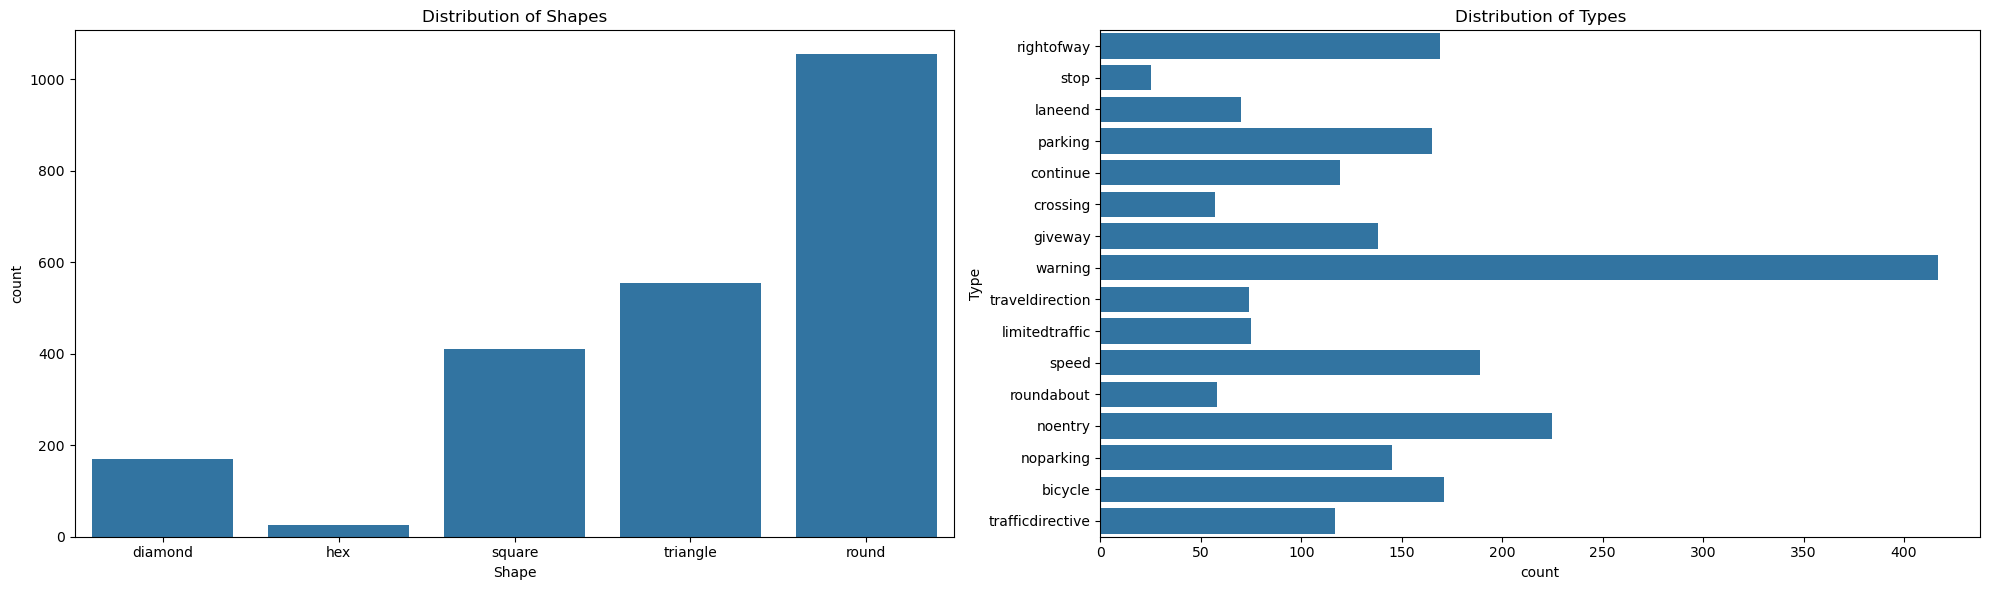

In [16]:
visualise_data(train)

In [17]:
# Iterate through each image path in the DataFrame
def check_image_dimensions(df):
    for index, row in df.iterrows():
        image_path = row['Path']
        flag = False

        # Open the image using PIL
        with Image.open(image_path) as img:
            width, height = img.size
            # Check if dimensions are not 28x28
            if width != 28 or height != 28:
                flag = True
                print(f"Image at path {image_path} has dimensions {width}x{height}")

    if not flag:
        return "All images have dimensions 28x28"

In [18]:
print(f"Train: {check_image_dimensions(train)}\n Test: {check_image_dimensions(test)}\n Val: {check_image_dimensions(val)}")    

Train: All images have dimensions 28x28
 Test: All images have dimensions 28x28
 Val: All images have dimensions 28x28


Display images

In [22]:
def load_image(image_path):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_image(image, channels=3)
    image = tf.image.resize(image, [150, 150])  
    return image

In [52]:
def display_images(data, column, num_images):
    categories = data[column].unique()  # Get unique categories in the specified column
    
    for cat in categories:
        # Filter data for the current category
        category_data = data[data[column] == cat]
        
        # Sample a subset of images for display (up to num_images)
        sample_paths = category_data['Path'].sample(min(num_images, len(category_data))).values
        
        # Display images for the current category
        plt.figure(figsize=(15, 2))
        plt.suptitle(f'{column}: {cat}', fontsize=10)
        for i, image_path in enumerate(sample_paths):
            image = load_image(image_path).numpy().astype("uint8")
            ax = plt.subplot(1, num_images, i + 1)
            plt.imshow(image)
            # plt.title(cat)
            plt.axis("off")
        plt.show()


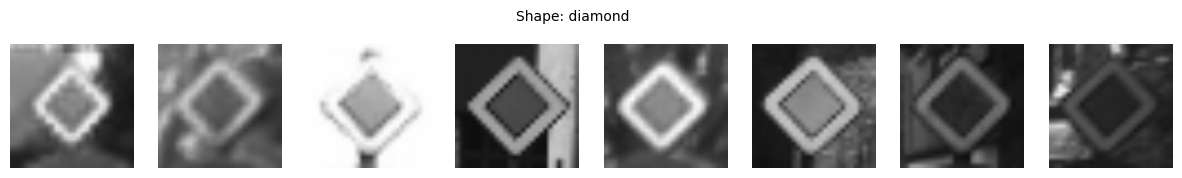

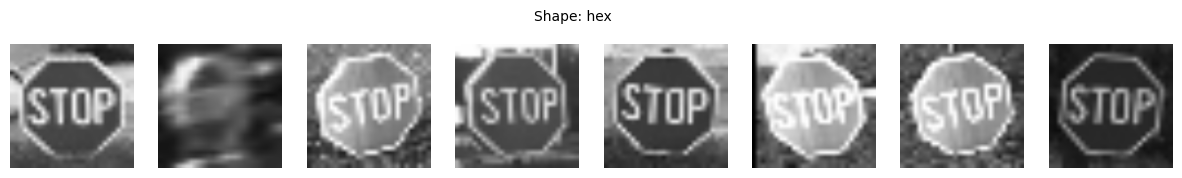

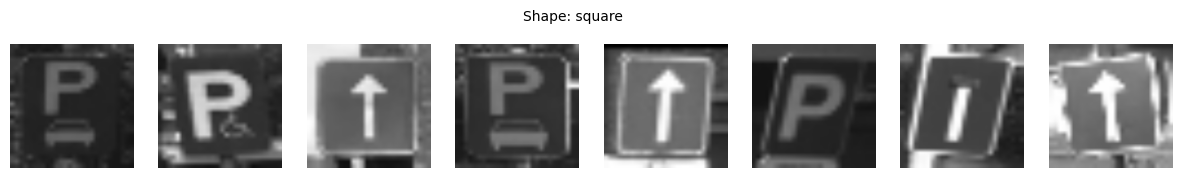

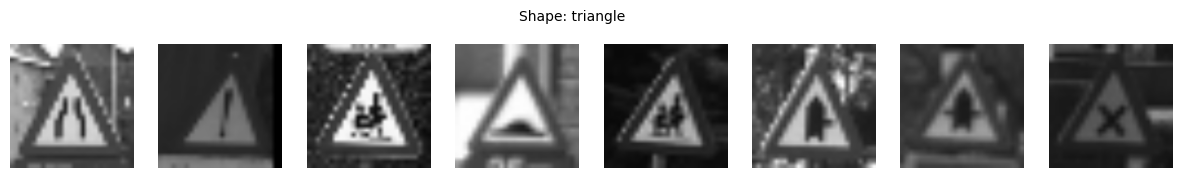

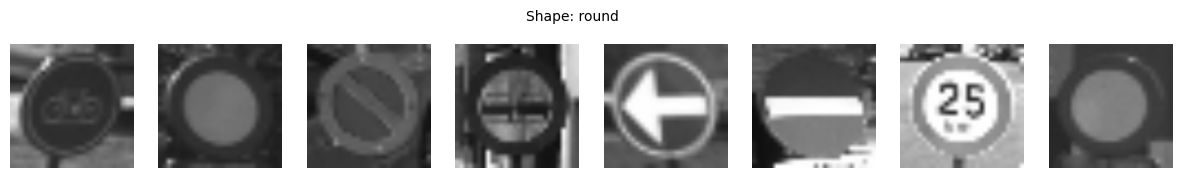

In [53]:
display_images(train, "Shape", 8)

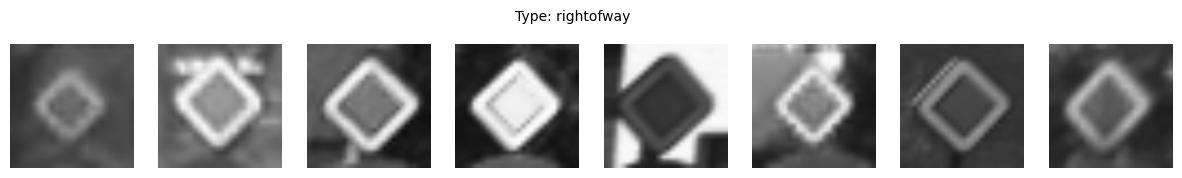

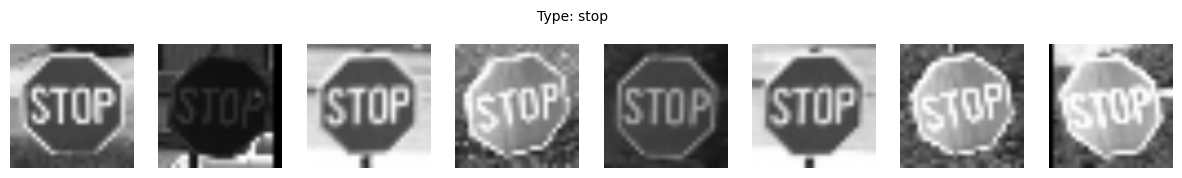

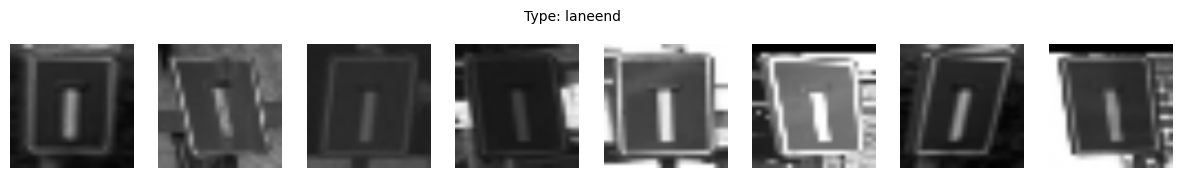

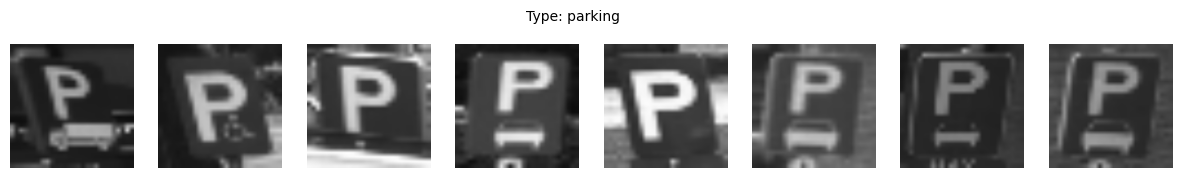

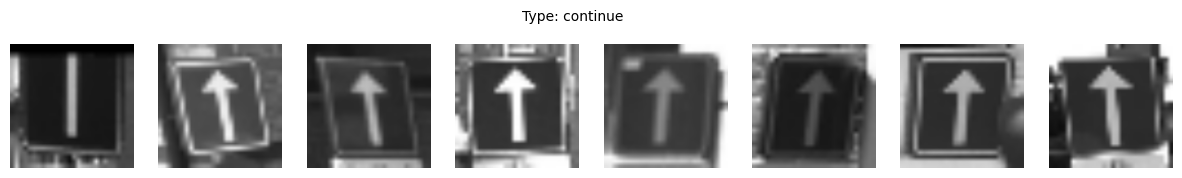

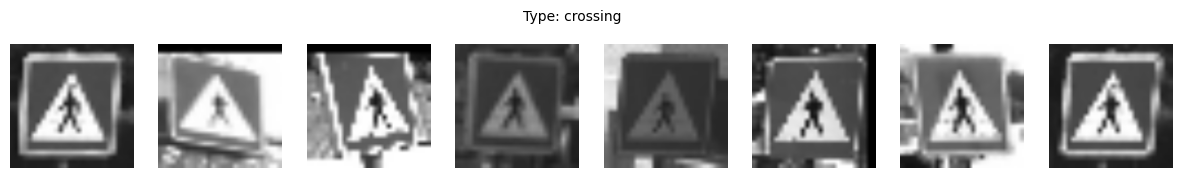

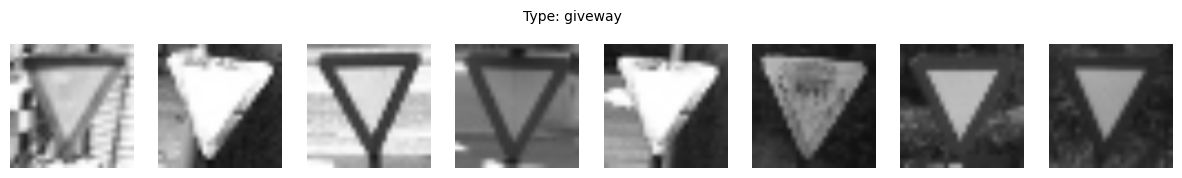

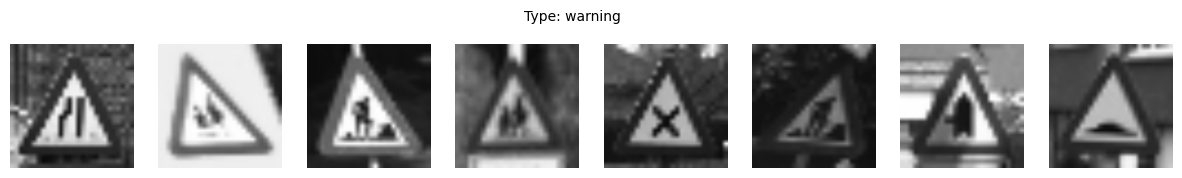

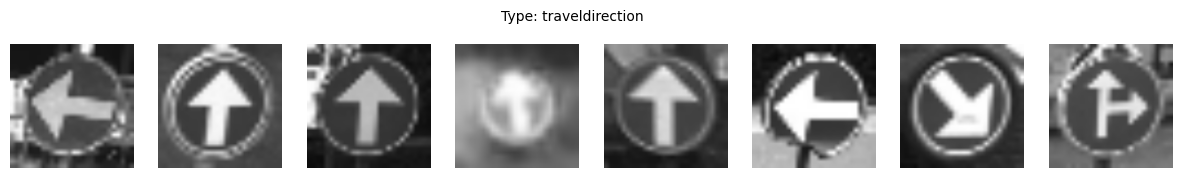

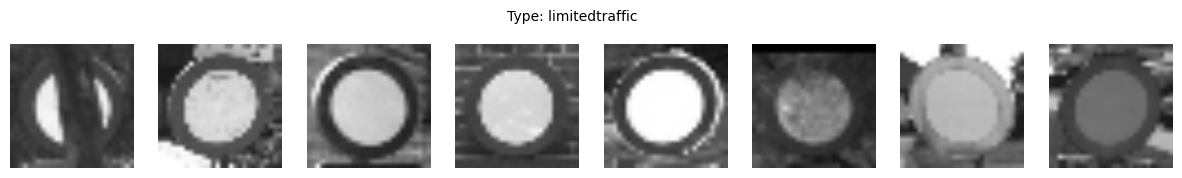

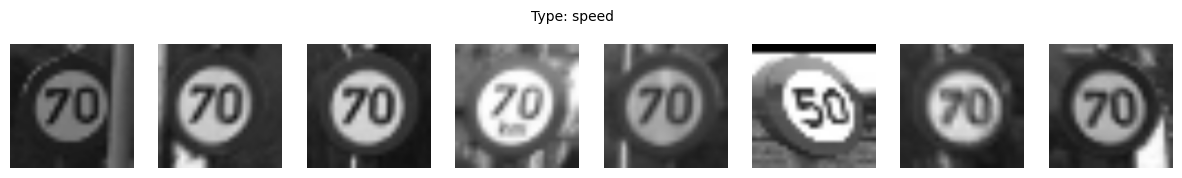

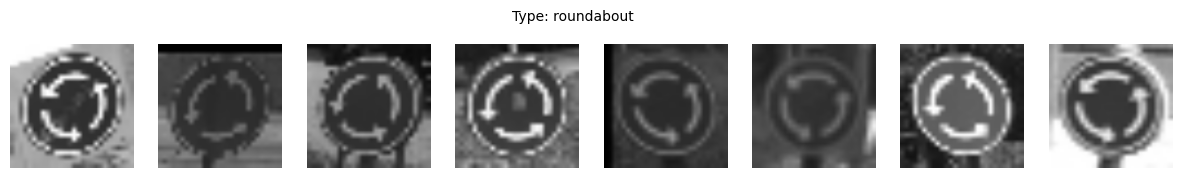

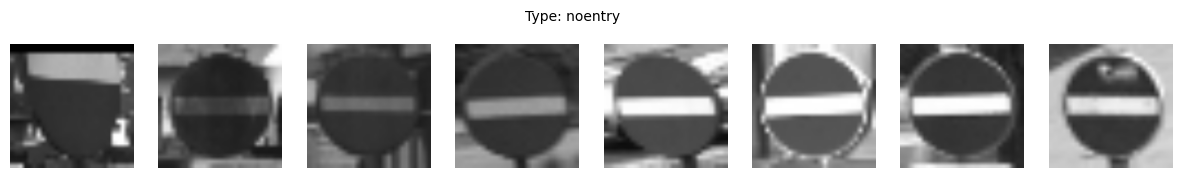

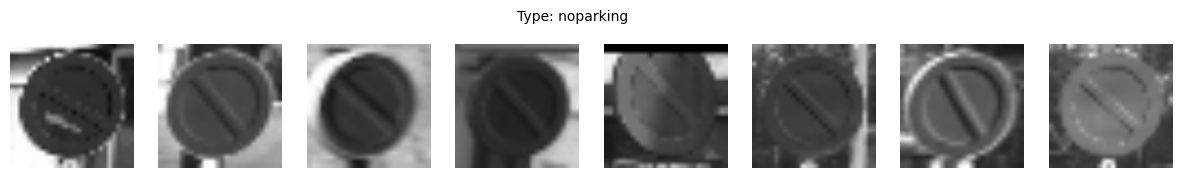

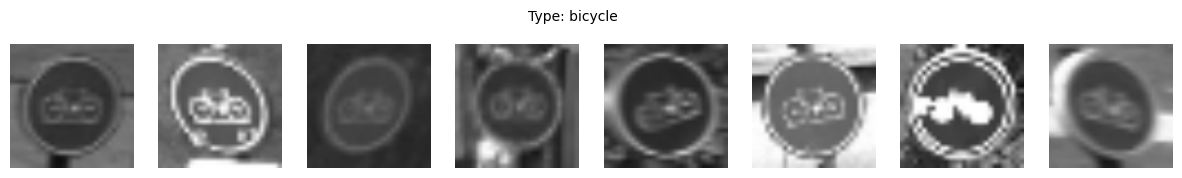

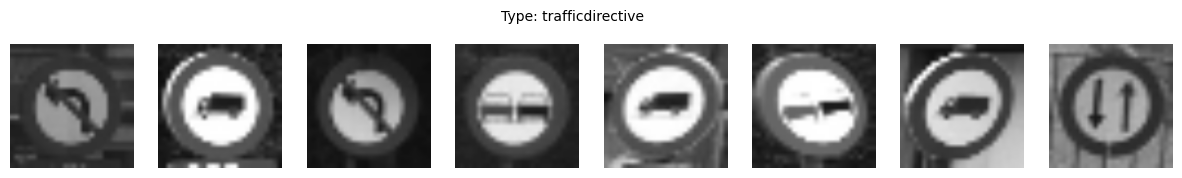

In [54]:
display_images(train, "Type", 8)

Encode class labels

In [162]:
def encoder(df):
    label_encoder = LabelEncoder()
    df['Shape'] = label_encoder.fit_transform(df['Shape'])
    df['Type'] = label_encoder.fit_transform(df['Type'])

    mapping = pd.DataFrame({
    'Type': label_encoder.classes_,
    'Encoded_Value': range(len(label_encoder.classes_))
    })

    print(mapping)

    return df    

In [236]:
encoder(train)
encoder(test)
encoder(val)

print(train['Shape'].value_counts())
print(train['Type'].value_counts())
train[train.Shape == 1].head()

                Type  Encoded_Value
0            bicycle              0
1           continue              1
2           crossing              2
3            giveway              3
4            laneend              4
5     limitedtraffic              5
6            noentry              6
7          noparking              7
8            parking              8
9         rightofway              9
10        roundabout             10
11             speed             11
12              stop             12
13  trafficdirective             13
14   traveldirection             14
15           warning             15
   Type  Encoded_Value
0     0              0
1     1              1
2    10              2
3    11              3
4    12              4
5    13              5
6    14              6
7    15              7
8     2              8
9     3              9
10    4             10
11    5             11
12    6             12
13    7             13
14    8             14
15    9             

Path  Shape  Type
169  Dataset/train_test_val/train/hex/stop/01951_00...      1    12
170  Dataset/train_test_val/train/hex/stop/01811_00...      1    12
171  Dataset/train_test_val/train/hex/stop/01920_00...      1    12
172  Dataset/train_test_val/train/hex/stop/01811_00...      1    12
173  Dataset/train_test_val/train/hex/stop/01811_00...      1    12

Handle Data Imbalance

In [58]:
def augment_data(df, image_batch_size, dest):
    
    images = []
    for image_path in df['Path']:
        img = plt.imread(image_path)
        images.append(img_to_array(img))
      

    datagen = ImageDataGenerator(
        rotation_range=20,
        zoom_range=0.2,
        horizontal_flip=True,
        vertical_flip=True,
        shear_range=0.2,
    )

    for img in images:
        img = img.reshape((1,) + img.shape)
        for j, _ in enumerate(datagen.flow(img, save_to_dir=dest, batch_size=1, save_prefix='aug', save_format='png')):
            if j >= image_batch_size:
                break


In [59]:
def make_dir(src, dest):
    if (os.path.exists(dest)):
        if dest == 'Dataset/shape_aug/train':
            shutil.rmtree(r'./Dataset/shape_aug/train')
        elif dest == 'Dataset/type_aug/train':
            shutil.rmtree(r'./Dataset/type_aug/train')
    
    shutil.copytree(src, dest)

In [60]:
def start_shape_augmentation(train, choice, src, dest, batch_dict):
    make_dir(src=src, dest=dest)
    
    for key, [index, value, shape] in batch_dict.items():
        path = dest + '/' + shape + '/' + key
        augment_data(df=train[train.Type == index], image_batch_size=value, dest=path) 
    
    train_aug = fetch_images(dest + '/*/*/*.png')
    train_aug = encoder(train_aug)
    print(train_aug[choice].value_counts())
    visualise_data(train_aug)
    return train_aug

Shape
2    1054
1    1011
3     915
4     827
0     820
Name: count, dtype: int64


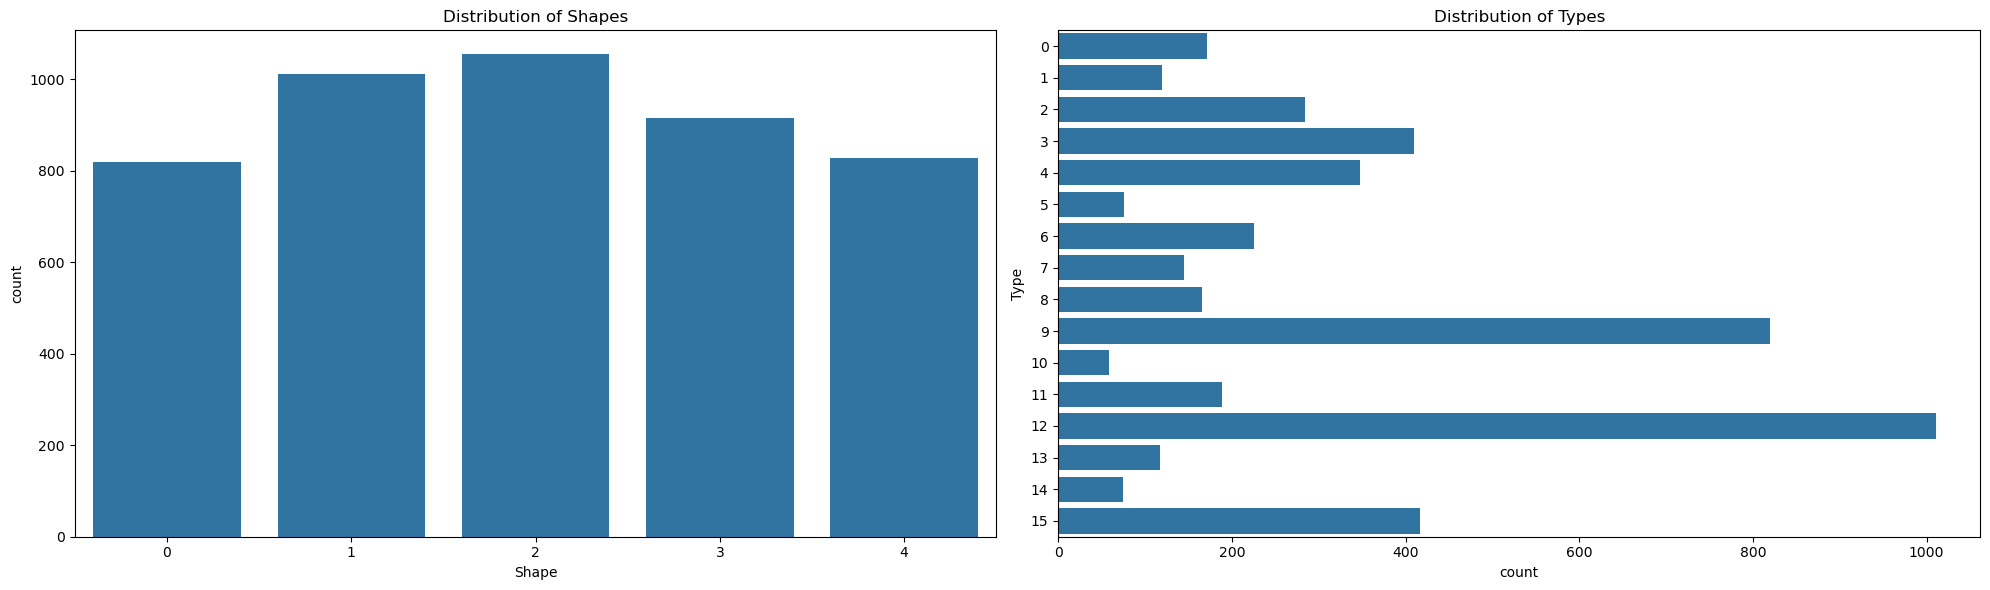

In [61]:
batch_dict_shape = {
    # sign_type : [sign_type_label, number of images to generate per image, shape]
        'stop': [12, 41, 'hex'],
        'giveway': [3, 1, 'triangle'],
        'crossing': [2, 3, 'square'],
        'laneend': [4, 3, 'square'],
        'rightofway': [9, 3, 'diamond'],
    }
train_shape_aug = start_shape_augmentation(train, 'Shape', 
                                           src='Dataset/train_test_val/train', 
                                           dest='Dataset/shape_aug/train', 
                                           batch_dict=batch_dict_shape)

In [64]:
value_counts = train_shape_aug.groupby(['Shape', 'Type']).size().reset_index(name='counts')

print(value_counts)

    Shape  Type  counts
0       0     9     820
1       1    12    1011
2       2     0     171
3       2     5      75
4       2     6     225
5       2     7     145
6       2    10      58
7       2    11     189
8       2    13     117
9       2    14      74
10      3     1     119
11      3     2     284
12      3     4     347
13      3     8     165
14      4     3     410
15      4    15     417


Type
6     662
13    576
7     570
11    564
3     548
5     513
14    507
2     506
0     504
9     503
8     492
4     482
1     468
10    449
12    437
15    417
Name: count, dtype: int64


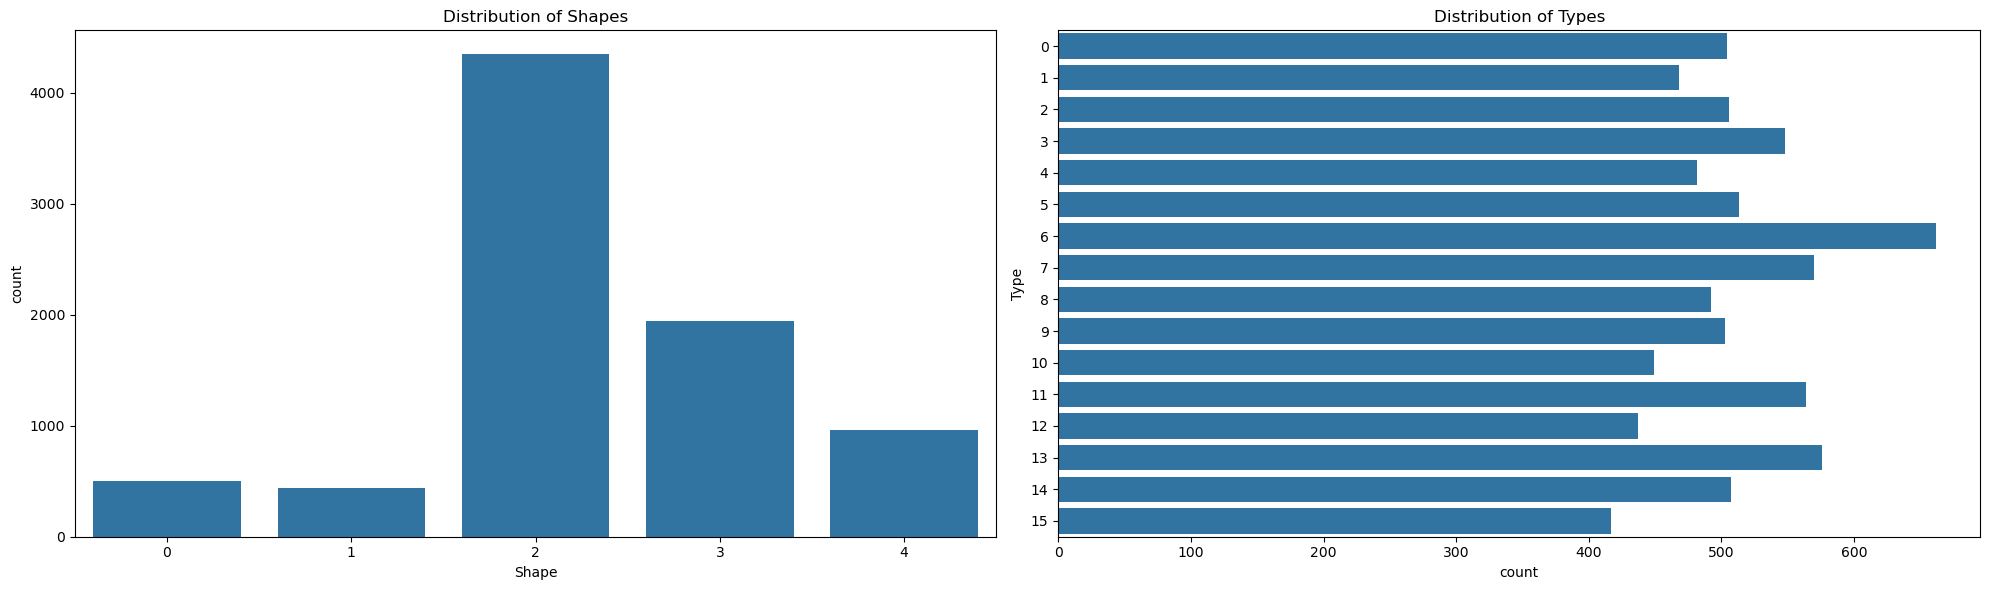

In [62]:
batch_dict_type = {
    # sign_type : [sign_type_label, number of images to generate per image, shape]
        'stop': [12, 16, 'hex'],
        'crossing': [2, 7, 'square'],
        'roundabout': [10, 6, 'round'],
        'laneend': [4, 5, 'square'],
        'traveldirection': [14, 5, 'round'],
        'limitedtraffic': [5, 5, 'round'],
        'trafficdirective': [13, 3, 'round'],
        'continue': [1, 2, 'square'],
        'giveway': [3, 2, 'triangle'],
        'noparking': [7, 2, 'round'],
        'parking': [8, 1, 'square'],
        'rightofway': [9, 1, 'diamond'],
        'bicycle': [0, 1, 'round'],
        'speed': [11, 1, 'round'], 
        'noentry': [6, 1, 'round'],
    }
train_type_augmented = start_shape_augmentation(train, 'Type', 
                                           src='Dataset/train_test_val/train', 
                                           dest='Dataset/type_aug/train', 
                                           batch_dict=batch_dict_type)

In [65]:
value_counts = train_type_augmented.groupby(['Shape', 'Type']).size().reset_index(name='counts')

print(value_counts)

    Shape  Type  counts
0       0     9     503
1       1    12     437
2       2     0     504
3       2     5     513
4       2     6     662
5       2     7     570
6       2    10     449
7       2    11     564
8       2    13     576
9       2    14     507
10      3     1     468
11      3     2     506
12      3     4     482
13      3     8     492
14      4     3     548
15      4    15     417


Generate Images for Training

In [247]:
def create_image_batches(df, batch_size, label, target_size=(28, 28), is_train = True):
        df[label] = df[label].astype('str')
        train_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')

        if is_train:
                train_generator = train_datagen.flow_from_dataframe(
                        dataframe=df,
                        directory='./',
                        x_col="Path",
                        y_col=label,
                        target_size=target_size,
                        batch_size=batch_size,
                        class_mode='categorical',
                        color_mode='grayscale')
        else:
                train_generator = train_datagen.flow_from_dataframe(
                        dataframe=df,
                        directory='./',
                        x_col="Path",
                        y_col=label,
                        target_size=target_size,
                        batch_size=batch_size,
                        shuffle=False,
                        class_mode='categorical',
                        color_mode='grayscale')
        
        return train_generator

In [248]:
# create image batches from train for Shape
shape_train_generator = create_image_batches(df=train, batch_size=32, label='Shape', target_size=(28, 28), is_train=True)
shape_val_generator = create_image_batches(df=val, batch_size=32, label='Shape', target_size=(28, 28), is_train=True)
shape_test_generator = create_image_batches(df=test, batch_size=32, label='Shape', target_size=(28, 28), is_train=True)
# create image batches from augmented train for Shape
shape_aug_train_generator = create_image_batches(df=train_shape_aug, batch_size=32, label='Shape', target_size=(28, 28), is_train=True)

Found 2214 validated image filenames belonging to 5 classes.
Found 735 validated image filenames belonging to 5 classes.
Found 750 validated image filenames belonging to 5 classes.
Found 4627 validated image filenames belonging to 5 classes.


In [228]:
type_train_generator = create_image_batches(df=train, batch_size=32, label='Type', target_size=(28, 28), is_train=True)
type_val_generator = create_image_batches(df=val, batch_size=32, label='Type', target_size=(28, 28), is_train=True)
type_test_generator = create_image_batches(df=test, batch_size=32, label='Type', target_size=(28, 28), is_train=True)
# create image batches from augmented train for Type
type_aug_train_generator = create_image_batches(df=train_type_augmented, batch_size=32, label='Type', target_size=(28, 28), is_train=True)

Found 2214 validated image filenames belonging to 16 classes.
Found 735 validated image filenames belonging to 16 classes.
Found 750 validated image filenames belonging to 16 classes.
Found 8198 validated image filenames belonging to 16 classes.


Model Development

In [249]:
OUTPUT_CLASSES_SHAPE = 5
OUTPUT_CLASSES_TYPE = 16
INPUT_DIM = (28, 28, 3)
# define metrics
METRIC = tf.keras.metrics.AUC(curve='PR', name='PR', from_logits=True)
LOSS_METRIC = tf.keras.losses.CategoricalCrossentropy(from_logits=True)


print(
    f"Classes_Shape: {OUTPUT_CLASSES_SHAPE}\n"
    f"Classes_Type: {OUTPUT_CLASSES_TYPE}\n"
    f"Metric: {METRIC}\n"
    f"Loss Metric: {LOSS_METRIC}\n"
)

Classes_Shape: 5
Classes_Type: 16
Metric: <AUC name=PR>
Loss Metric: <keras.src.losses.losses.CategoricalCrossentropy object at 0x48add0a10>



In [230]:
def plot_learning_curve(train_loss, val_loss, train_metric, val_metric, metric_name='Accuracy'):
    plt.figure(figsize=(10,5))
    
    plt.subplot(1,2,1)
    plt.plot(train_loss, 'r--')
    plt.plot(val_loss, 'b--')
    plt.xlabel("epochs")
    plt.ylabel("Loss")
    plt.legend(['train', 'val'], loc='upper left')

    plt.subplot(1,2,2)
    plt.plot(train_metric, 'r--')
    plt.plot(val_metric, 'b--')
    plt.xlabel("epochs")
    plt.ylabel(metric_name)
    plt.legend(['train', 'val'], loc='upper left')

    plt.show()

In [231]:
def plot_performance(history, metric_label):
    val_metric_label = 'val_' + metric_label
    plot_learning_curve(history.history['loss'], history.history['val_loss'], 
                    history.history[metric_label], history.history[val_metric_label], 
                    metric_name = metric_label)

In [232]:
def calc_class_weights(df, label):
    unique_labels = train[label].unique()
    weights =  compute_class_weight(class_weight="balanced", classes=df[label].unique(), y=df[label].to_numpy())
    class_weights = dict(zip(unique_labels, weights))
    return class_weights

In [233]:
def tune_model(tuner, train_generator, val_generator, class_weights, epoch, tune_type):
    tuner.search(train_generator, validation_data=val_generator, class_weight=class_weights, epochs=epoch, verbose=0)
    best_hp = tuner.get_best_hyperparameters()[0]
    tuned_val = best_hp.get(tune_type)
    print(f"Best {tune_type}: {tuned_val}")
    model = tuner.hypermodel.build(best_hp)
    history = model.fit(train_generator, validation_data=val_generator, epochs=epoch, verbose=0, class_weight=class_weights)
    plot_performance(history=history, metric_label='PR')
    return model

Fetch class weights

In [237]:
shape_weights = calc_class_weights(df=train, label='Shape')
shape_weights

{0: 2.620118343195266,
 1: 17.712,
 3: 1.0773722627737226,
 4: 0.7978378378378378,
 2: 0.42011385199240986}

In [238]:
type_weights = calc_class_weights(df=train, label='Type')
type_weights

{9: 0.8187869822485208,
 12: 5.535,
 4: 1.9767857142857144,
 8: 0.8386363636363636,
 1: 1.1628151260504203,
 2: 2.4276315789473686,
 3: 1.002717391304348,
 15: 0.3318345323741007,
 14: 1.8699324324324325,
 5: 1.845,
 11: 0.7321428571428571,
 10: 2.3857758620689653,
 6: 0.615,
 7: 0.9543103448275863,
 0: 0.8092105263157895,
 13: 1.1826923076923077}

### Models

Base MLP

In [250]:
def baseline_mlp(output_class):

    
        INPUT_DIM = (28,28,1)
        HIDDEN_LAYER_DIM = 400
        OUTPUT_CLASSES = output_class
        
        AUTOTUNE = tf.data.experimental.AUTOTUNE

        model = tf.keras.Sequential([
        
        tf.keras.layers.Flatten(input_shape=INPUT_DIM),
        tf.keras.layers.Dense(HIDDEN_LAYER_DIM, activation='relu'),
        tf.keras.layers.Dense(OUTPUT_CLASSES)
        ])

        model.summary()

        return model
        


Base VGG

In [92]:
def build_model_VGG(input_shape, output_classes, activation='relu'):
    model = tf.keras.Sequential([
        tf.keras.layers.Conv2D(28, (3, 3), activation=activation, padding='same', input_shape=input_shape),
        tf.keras.layers.Conv2D(28, (3, 3), activation=activation, padding='same'),
        tf.keras.layers.MaxPooling2D((2, 2)),
   
        tf.keras.layers.Conv2D(64, (3, 3), activation=activation, padding='same'),
        tf.keras.layers.Conv2D(64, (3, 3), activation=activation, padding='same'),
        tf.keras.layers.MaxPooling2D((2, 2)),
        
        tf.keras.layers.Conv2D(128, (3, 3), activation=activation, padding='same'),
        tf.keras.layers.Conv2D(128, (3, 3), activation=activation, padding='same'),
        tf.keras.layers.MaxPooling2D((2, 2)),
        
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(128, activation=activation),
        tf.keras.layers.Dense(output_classes, activation='softmax'),
    ])

    return model

Tuneable VGG with L2 Regularization

In [93]:
def build_model_VGG_reg(hp, output_class):    
    lambda_value = hp.Float('lambda', min_value=0.0001, max_value=0.1, sampling='log', default=0.001)
    model = tf.keras.Sequential([
        
        tf.keras.layers.Conv2D(28, (3, 3), activation='relu', padding='same', 
                            kernel_regularizer=tf.keras.regularizers.l2(lambda_value), input_shape=INPUT_DIM),
        tf.keras.layers.Conv2D(28, (3, 3), activation='relu', padding='same', 
                            kernel_regularizer=tf.keras.regularizers.l2(lambda_value)),
        tf.keras.layers.MaxPooling2D((2, 2)),
        
        
        tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same', 
                            kernel_regularizer=tf.keras.regularizers.l2(lambda_value)),
        tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same', 
                            kernel_regularizer=tf.keras.regularizers.l2(lambda_value)),
        tf.keras.layers.MaxPooling2D((2, 2)),
        
        
        tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same', 
                            kernel_regularizer=tf.keras.regularizers.l2(lambda_value)),
        tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same', 
                            kernel_regularizer=tf.keras.regularizers.l2(lambda_value)),
        tf.keras.layers.MaxPooling2D((2, 2)),
        
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(output_class, activation = "softmax"),
    ])

    model.compile(optimizer='sgd', loss='categorical_crossentropy', metrics=[METRIC])

    return model

Tunable VGG with Dropout Regularization

In [94]:
def build_model_VGG_dropout(hp):    
    # from lambda tuner
    #lambda_value = 0.018037870215070927
    lambda_value = 0.006407366308178109
    dropout_value = hp.Float('dropout_rate', min_value=0.2, max_value=0.5, default=0.2, step=0.1)
    model = tf.keras.Sequential([
        
        tf.keras.layers.Conv2D(28, (3, 3), activation='relu', padding='same', 
                            kernel_regularizer=tf.keras.regularizers.l2(lambda_value), input_shape=INPUT_DIM),
        tf.keras.layers.Conv2D(28, (3, 3), activation='relu', padding='same', 
                            kernel_regularizer=tf.keras.regularizers.l2(lambda_value)),
        tf.keras.layers.MaxPooling2D((2, 2)),
        
        
        tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same', 
                            kernel_regularizer=tf.keras.regularizers.l2(lambda_value)),
        tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same', 
                            kernel_regularizer=tf.keras.regularizers.l2(lambda_value)),
        tf.keras.layers.MaxPooling2D((2, 2)),
        
        
        tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same', 
                            kernel_regularizer=tf.keras.regularizers.l2(lambda_value)),
        tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same', 
                            kernel_regularizer=tf.keras.regularizers.l2(lambda_value)),
        tf.keras.layers.MaxPooling2D((2, 2)),
        
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dropout(dropout_value),
        tf.keras.layers.Dense(OUTPUT_CLASSES_SHAPE, activation = "softmax"),
    ])

    model.compile(optimizer='sgd', loss='categorical_crossentropy', metrics=[METRIC])

    return model

### Tuners

Lambda Tuner

In [95]:
# Initialize the l2 tuner
lambda_tuner = kt.RandomSearch(
    build_model_VGG_reg,
    objective='val_loss',
    max_trials=3,
    project_name='lambda_tuning')

Reloading Tuner from ./lambda_tuning/tuner0.json


Dropout Tuner

In [96]:
# Initialize the droput tuner
dropout_tuner = kt.RandomSearch(
    build_model_VGG_dropout,
    objective='val_loss',
    max_trials=5,
    project_name='dropout_tuning')

Reloading Tuner from ./dropout_tuning/tuner0.json


Baseline Model

In [86]:
def compile_model(model, optimiser='sgd', loss='categorical_crossentropy', metrics=['categorical_accuracy']):
    model.compile(optimizer=optimiser, loss=loss, metrics=metrics)
    return model

In [87]:
def train_model(model, train_generator, val_generator, epochs=50, class_weights=None):
    history = model.fit(train_generator, validation_data=val_generator, epochs=epochs, class_weight=class_weights, verbose=0)
    return history

In [ ]:
# def pipeline(train, val, metric_label, optimiser, activation, epoch, class_weights):
#     model = build_model_VGG(input_shape=INPUT_DIM, output_classes=OUTPUT_CLASSES_SHAPE, activation=activation)
#     model = compile_model(model, optimiser=optimiser, loss=LOSS_METRIC, metrics=[METRIC])
#     history = train_model(model, train, val, epochs=epoch, class_weights=class_weights)
#     plot_performance(history=history, metric_label=metric_label)
#     return model


In [90]:
def pipeline(model_fn, train, val, metric_label, optimiser, activation, epoch, class_weights):
    model = model_fn
    model = compile_model(model, optimiser=optimiser, loss=LOSS_METRIC, metrics=[METRIC])
    history = train_model(model, train, val, epochs=epoch, class_weights=class_weights)
    plot_performance(history=history, metric_label=metric_label)
    return model


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_31"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_31 (Flatten)            │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_62 (Dense)                │ (None, 400)            │       314,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_63 (Dense)                │ (None, 5)              │         2,005 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 316,005 (1.21 MB)

 Trainable params: 316,005 (1.21 MB)

 Non-trainable params: 0 (0.00 B)

/opt/anaconda3/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


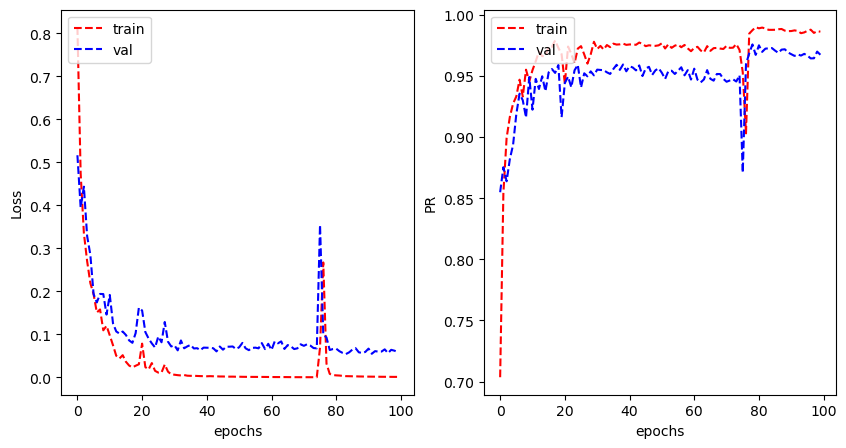

In [251]:
baseline_mlp_model_shape = pipeline(baseline_mlp(5),
                              shape_train_generator, 
                              shape_val_generator, 
                              metric_label='PR',
                              optimiser='adam',
                              activation='relu',
                              epoch=100,
                              class_weights=None)

In [145]:
baseline_mlp_model_shape.save('models/shape/mbaseline_mlp_model_shape.keras')

Convolutional Neural Network (CNN)

VGG with Adam Optimiser

/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/opt/anaconda3/lib/python3.11/site-packages/keras/src/backend/tensorflow/nn.py:585: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


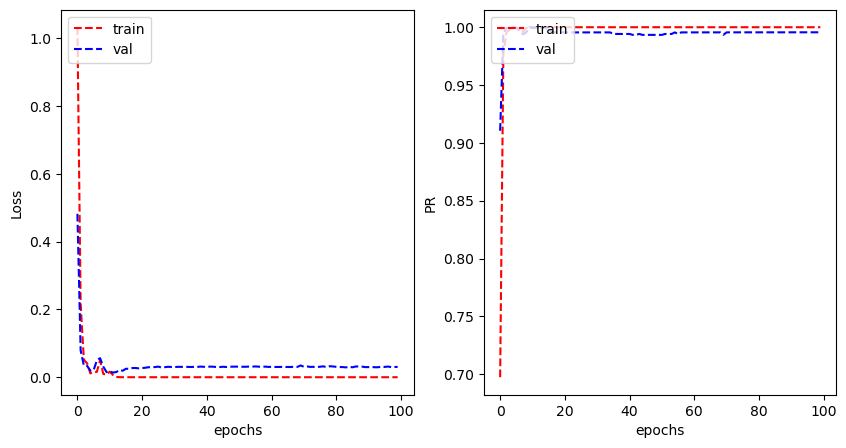

In [101]:
model_VGG_base_adam_shape = pipeline(build_model_VGG(input_shape=INPUT_DIM,output_classes=5, activation='relu'),
                        shape_train_generator, 
                        shape_val_generator, 
                        metric_label='PR',
                        optimiser='adam',
                        activation='relu',
                        epoch=100,
                        class_weights=None)

In [146]:
model_VGG_base_adam_shape.save('models/shape/model_VGG_base_adam_shape.keras')

VGG with SGD Optimiser

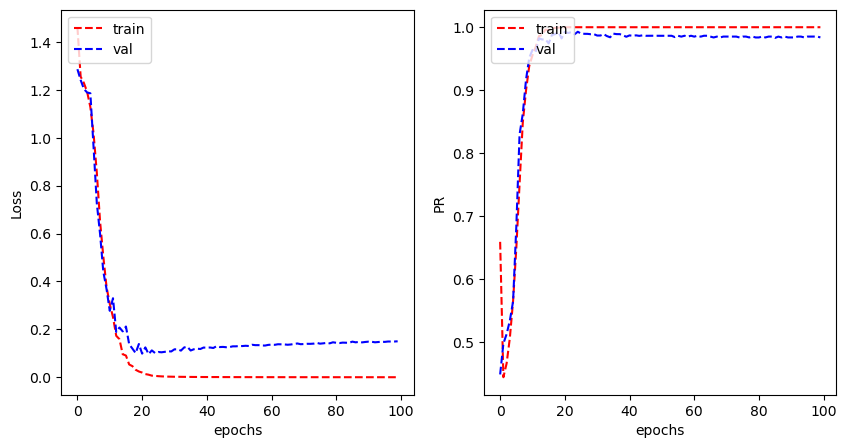

In [104]:
model_VGG_base_SGD_shape = pipeline(build_model_VGG(input_shape=INPUT_DIM,output_classes=5, activation='relu'),
                          shape_train_generator, 
                          shape_val_generator, 
                          metric_label='PR',
                          optimiser='sgd',
                          activation='relu',
                          epoch=100,
                          class_weights=None)

In [137]:
model_VGG_base_SGD_shape.save('models/shape/model_VGG_base_SGD_shape.keras')

Class Re-Weighting

VGG with Class Re-Weighting

/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_26"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_26 (Flatten)            │ (None, 2352)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_52 (Dense)                │ (None, 400)            │       941,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_53 (Dense)                │ (None, 5)              │         2,005 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 943,205 (3.60 MB)

 Trainable params: 943,205 (3.60 MB)

 Non-trainable params: 0 (0.00 B)

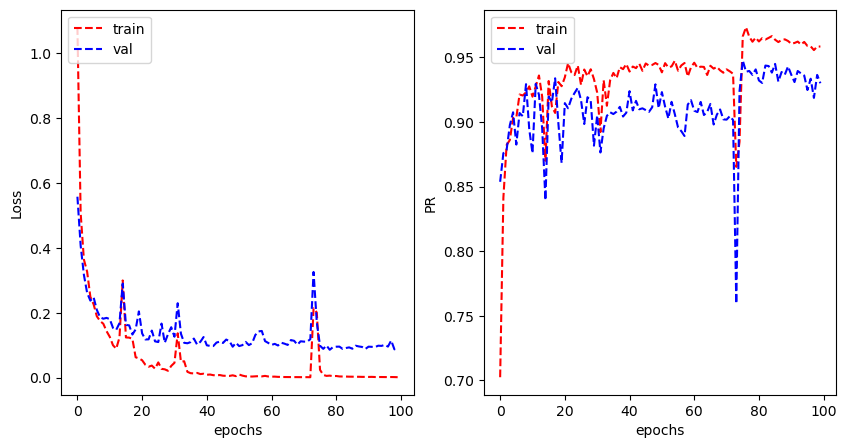

In [143]:
baseline_mlp_model_shape_reweighted = pipeline(baseline_mlp(5),
                              shape_train_generator, 
                              shape_val_generator, 
                              metric_label='PR',
                              optimiser='adam',
                              activation='relu',
                              epoch=100,
                              class_weights=shape_weights)

In [147]:
baseline_mlp_model_shape_reweighted.save('models/shape/baseline_mlp_model_shape_reweighted.keras')

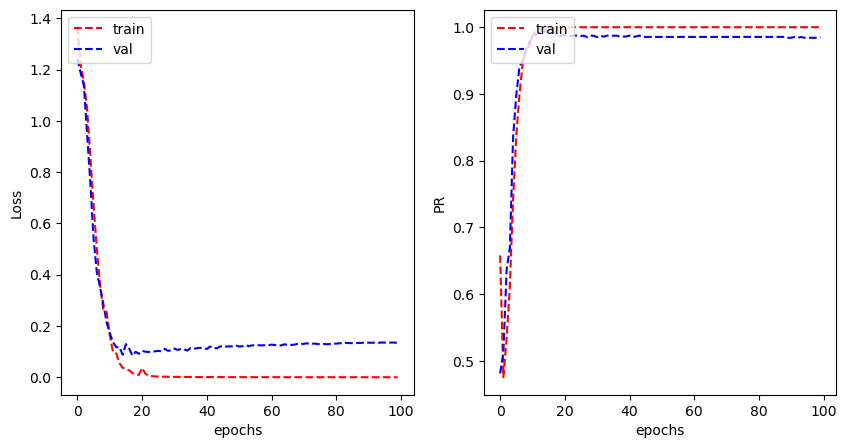

In [105]:
model_VGG_base_SGD_shape_reweighted = pipeline(build_model_VGG(input_shape=INPUT_DIM,output_classes=5, activation='relu'),
                                            shape_train_generator, 
                                            shape_val_generator, 
                                            metric_label='PR',
                                            optimiser='sgd',
                                            activation='relu',
                                            epoch=100,
                                            class_weights=shape_weights)

In [138]:
model_VGG_base_SGD_shape_reweighted.save('models/shape/model_VGG_base_SGD_shape_reweighted.keras')

L2 Regularisation

Best lambda: 0.0002182433505738606


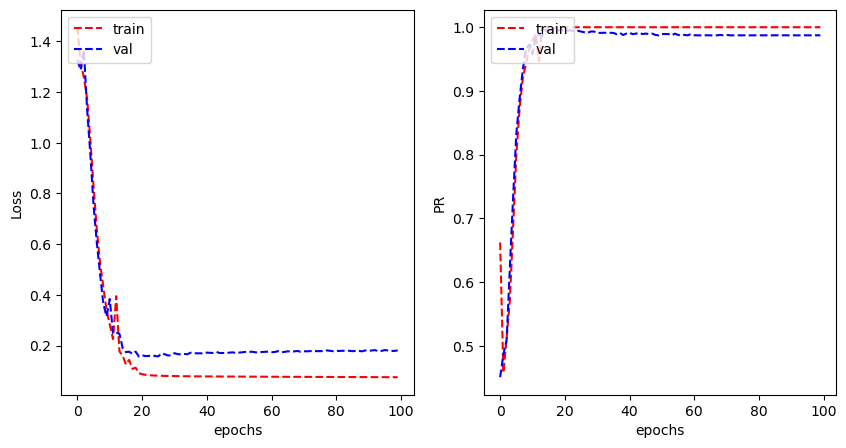

In [106]:
best_model_l2_shape = tune_model(lambda_tuner, shape_train_generator, shape_val_generator, shape_weights, 100, 'lambda')

In [139]:
best_model_l2_shape.save('models/shape/best_model_l2_shape.keras')

Dropout Regularisation

Best dropout_rate: 0.4


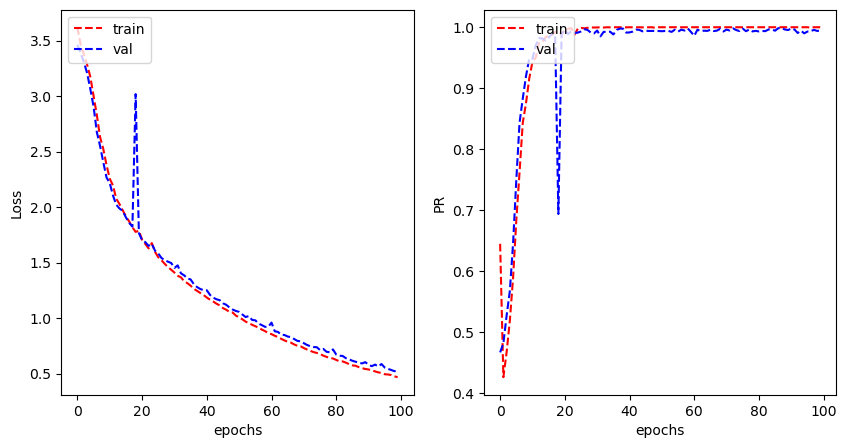

In [107]:
best_model_droput_shape = tune_model(dropout_tuner, shape_train_generator, shape_val_generator, shape_weights, 100, 'dropout_rate')

In [140]:
best_model_droput_shape.save('models/shape/best_model_droput_shape.keras')

Augmented Data

Model: "sequential_27"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_27 (Flatten)            │ (None, 2352)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_54 (Dense)                │ (None, 400)            │       941,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_55 (Dense)                │ (None, 5)              │         2,005 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 943,205 (3.60 MB)

 Trainable params: 943,205 (3.60 MB)

 Non-trainable params: 0 (0.00 B)

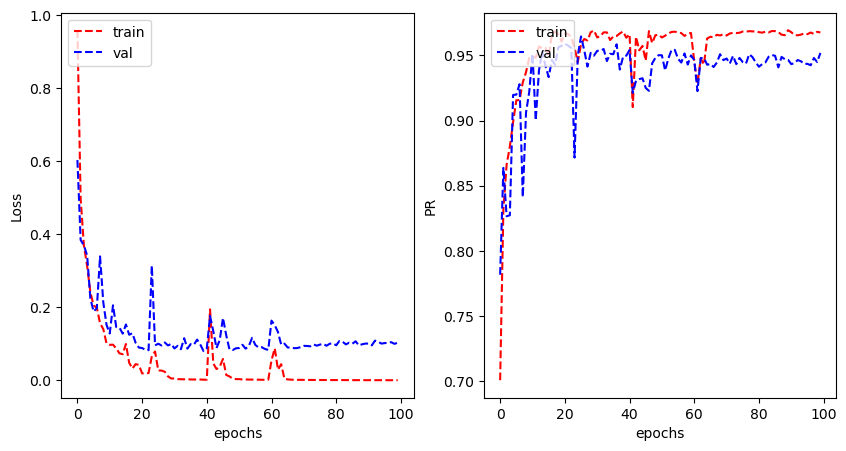

In [144]:
baseline_mlp_model_shape_aug = pipeline(baseline_mlp(5),
                              shape_aug_train_generator, 
                              shape_val_generator, 
                              metric_label='PR',
                              optimiser='adam',
                              activation='relu',
                              epoch=100,
                              class_weights=None)

In [148]:
baseline_mlp_model_shape_aug.save('models/shape/baseline_mlp_model_shape_aug.keras')

/opt/anaconda3/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


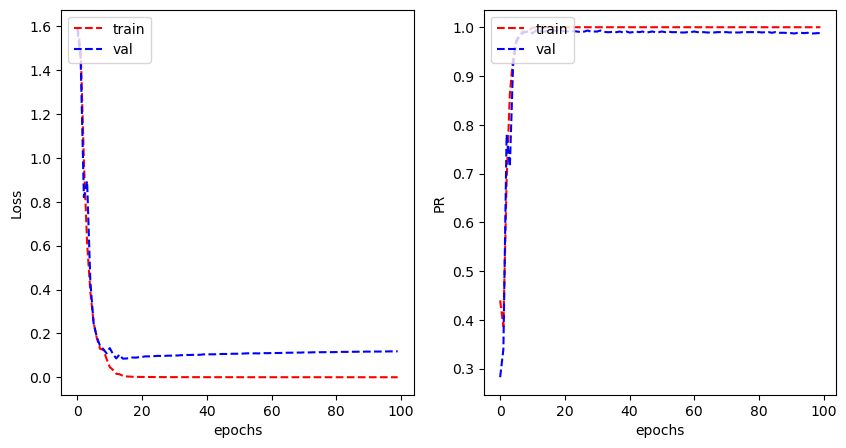

In [108]:
model_VGG_base_SGD_shape_aug = pipeline(build_model_VGG(input_shape=INPUT_DIM,output_classes=5, activation='relu'),
                          shape_aug_train_generator, 
                          shape_val_generator, 
                          metric_label='PR',
                          optimiser='sgd',
                          activation='relu',
                          epoch=100,
                          class_weights=None)

In [149]:
model_VGG_base_SGD_shape_aug.save('models/shape/model_VGG_base_SGD_shape_aug.keras')

Regularisation

Best lambda: 0.0002182433505738606


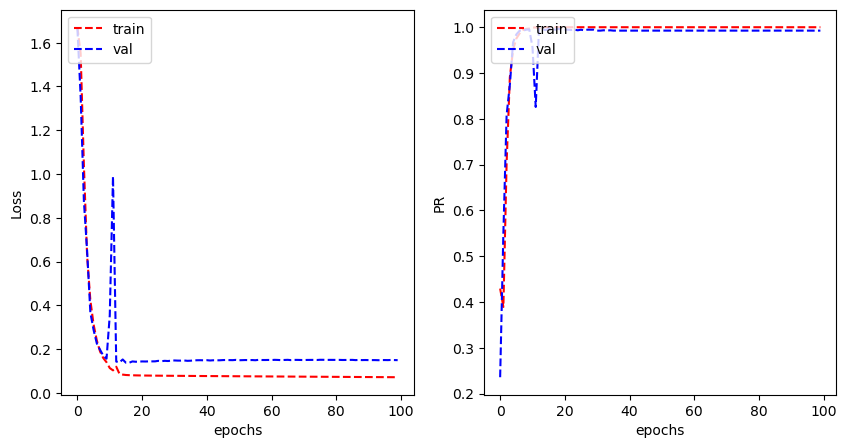

In [109]:
best_model_l2_shape_aug = tune_model(lambda_tuner, shape_aug_train_generator, shape_val_generator, shape_weights, 100, 'lambda')

In [141]:
best_model_l2_shape_aug.save('models/shape/best_model_l2_shape_aug.keras')

Dropout

Best dropout_rate: 0.4


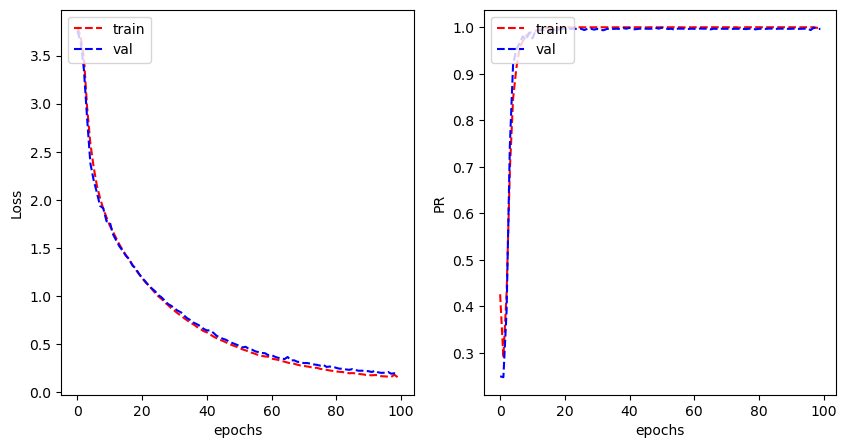

In [110]:
best_model_dropout_shape_aug = tune_model(dropout_tuner, shape_aug_train_generator, shape_val_generator, shape_weights, 100, 'dropout_rate')

In [142]:
best_model_dropout_shape_aug.save('models/shape/best_model_droput_shape_aug.keras')

Type

Base SGD Optimiser

In [ ]:
# def pipeline(train, val, metric_label, optimiser, activation, epoch, class_weights):
#     model = build_model_VGG(input_shape=INPUT_DIM, output_classes=OUTPUT_CLASSES_TYPE, activation=activation)
#     model = compile_model(model, optimiser=optimiser, loss=LOSS_METRIC, metrics=[METRIC])
#     history = train_model(model, train, val, epochs=epoch, class_weights=class_weights)
#     plot_performance(history=history, metric_label=metric_label)
#     return model


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_28"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_28 (Flatten)            │ (None, 2352)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_56 (Dense)                │ (None, 400)            │       941,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_57 (Dense)                │ (None, 16)             │         6,416 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 947,616 (3.61 MB)

 Trainable params: 947,616 (3.61 MB)

 Non-trainable params: 0 (0.00 B)

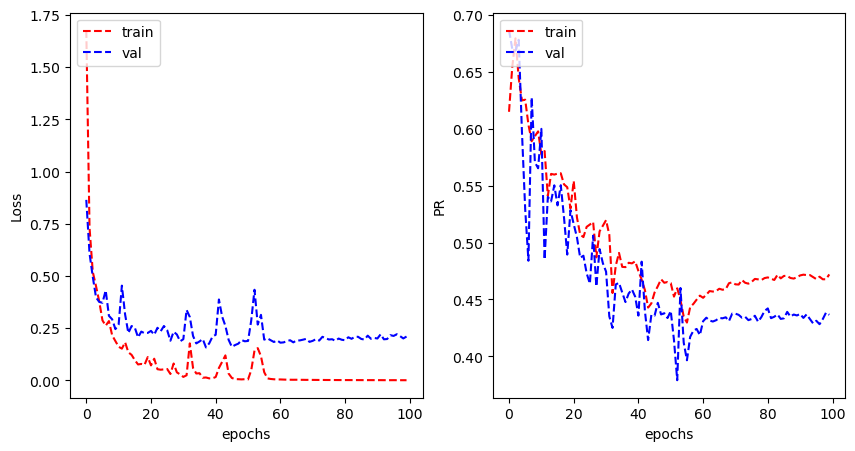

In [151]:
baseline_mlp_model_type = pipeline(baseline_mlp(16),
                              type_train_generator, 
                              type_val_generator, 
                              metric_label='PR',
                              optimiser='adam',
                              activation='relu',
                              epoch=100,
                              class_weights=None)

In [152]:
baseline_mlp_model_type.save('models/shape/baseline_mlp_model_type.keras')

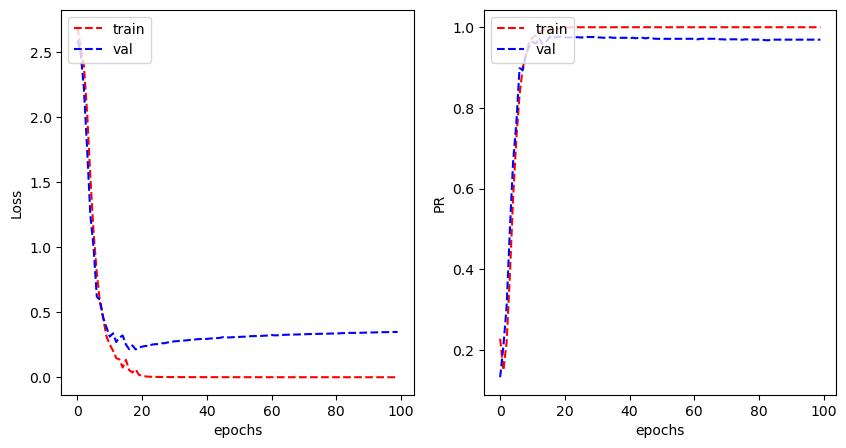

In [114]:
model_VGG_base_SGD_type = pipeline(build_model_VGG(input_shape=INPUT_DIM,output_classes=16, activation='relu'),
                          type_train_generator, 
                          type_val_generator, 
                          metric_label='PR',
                          optimiser='sgd',
                          activation='relu',
                          epoch=100,
                          class_weights=None)

In [153]:
model_VGG_base_SGD_type.save('models/type/model_VGG_base_SGD_type.keras')

Reweighted SGD Optimiser

/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_29"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_29 (Flatten)            │ (None, 2352)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_58 (Dense)                │ (None, 400)            │       941,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_59 (Dense)                │ (None, 16)             │         6,416 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 947,616 (3.61 MB)

 Trainable params: 947,616 (3.61 MB)

 Non-trainable params: 0 (0.00 B)

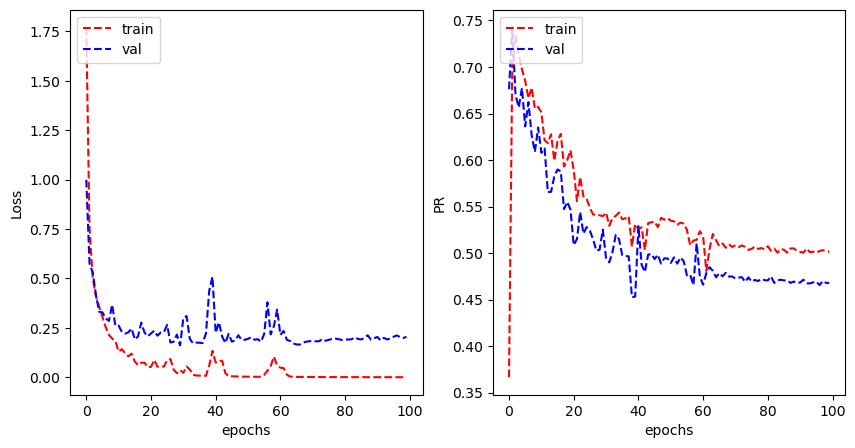

In [154]:
baseline_mlp_model_type_reweighted = pipeline(baseline_mlp(16),
                              type_train_generator, 
                              type_val_generator, 
                              metric_label='PR',
                              optimiser='adam',
                              activation='relu',
                              epoch=100,
                              class_weights=type_weights)

In [155]:
baseline_mlp_model_type_reweighted.save('models/type/baseline_mlp_model_type_reweighted.keras')

/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/opt/anaconda3/lib/python3.11/site-packages/keras/src/backend/tensorflow/nn.py:585: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


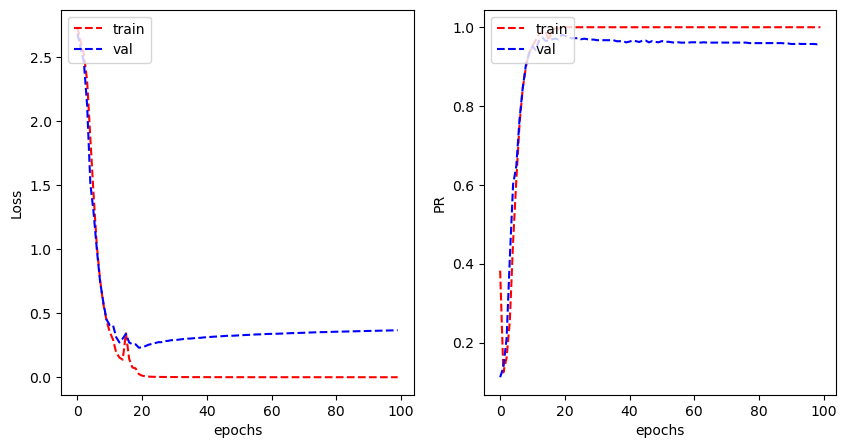

In [115]:
model_VGG_base_SGD_type_reweighted = pipeline(build_model_VGG(input_shape=INPUT_DIM,output_classes=16, activation='relu'),
                          type_train_generator, 
                          type_val_generator, 
                          metric_label='PR',
                          optimiser='sgd',
                          activation='relu',
                          epoch=100,
                          class_weights=type_weights)

In [156]:
model_VGG_base_SGD_type_reweighted.save('models/type/model_VGG_base_SGD_type_reweighted.keras')

L2 Regularisation

In [123]:
# def tune_model(tuner, train_generator, val_generator, class_weights, epoch, tune_type):
#     tuner.search(train_generator, validation_data=val_generator, class_weight=class_weights, epochs=epoch, verbose=0)
#     best_hp = tuner.get_best_hyperparameters()[0]
#     tuned_val = best_hp.get(tune_type)
#     print(f"Best {tune_type}: {tuned_val}")
#     model = tuner.hypermodel.build(best_hp)
#     history = model.fit(train_generator, validation_data=val_generator, epochs=epoch, verbose=0, class_weight=class_weights)
#     plot_performance(history=history, metric_label='PR')
#     return model

def tune_model(tuner, train_generator, val_generator, class_weights, epoch, tune_type, output_class):
    # Update the tuner to use the correct hypermodel building function
    tuner.hypermodel.build = lambda hp: build_model_VGG_reg(hp, output_class)
    
    # Perform hyperparameter search
    tuner.search(train_generator, validation_data=val_generator, class_weight=class_weights, epochs=epoch, verbose=0)
    
    best_hp = tuner.get_best_hyperparameters()[0]
    tuned_val = best_hp.get(tune_type)
    print(f"Best {tune_type}: {tuned_val}")
    
    # Build the model with the best hyperparameters
    model = tuner.hypermodel.build(best_hp)
    
    # Train the model with the best hyperparameters
    history = model.fit(train_generator, validation_data=val_generator, epochs=epoch, verbose=0, class_weight=class_weights)
    
    plot_performance(history=history, metric_label='PR')
    return model

In [124]:
def build_model_VGG_reg(hp, output_class):    
    lambda_value = hp.Float('lambda', min_value=0.0001, max_value=0.1, sampling='log', default=0.001)
    model = tf.keras.Sequential([
        
        tf.keras.layers.Conv2D(28, (3, 3), activation='relu', padding='same', 
                            kernel_regularizer=tf.keras.regularizers.l2(lambda_value), input_shape=INPUT_DIM),
        tf.keras.layers.Conv2D(28, (3, 3), activation='relu', padding='same', 
                            kernel_regularizer=tf.keras.regularizers.l2(lambda_value)),
        tf.keras.layers.MaxPooling2D((2, 2)),
        
        
        tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same', 
                            kernel_regularizer=tf.keras.regularizers.l2(lambda_value)),
        tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same', 
                            kernel_regularizer=tf.keras.regularizers.l2(lambda_value)),
        tf.keras.layers.MaxPooling2D((2, 2)),
        
        
        tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same', 
                            kernel_regularizer=tf.keras.regularizers.l2(lambda_value)),
        tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same', 
                            kernel_regularizer=tf.keras.regularizers.l2(lambda_value)),
        tf.keras.layers.MaxPooling2D((2, 2)),
        
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(output_class, activation = "softmax"),
    ])

    model.compile(optimizer='sgd', loss='categorical_crossentropy', metrics=[METRIC])

    return model

In [125]:
# Initialize the l2 tuner
lambda_tuner = kt.RandomSearch(
    build_model_VGG_reg,
    objective='val_loss',
    max_trials=3,
    project_name='lambda_tuning')

Reloading Tuner from ./lambda_tuning/tuner0.json


Best lambda: 0.0002182433505738606


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


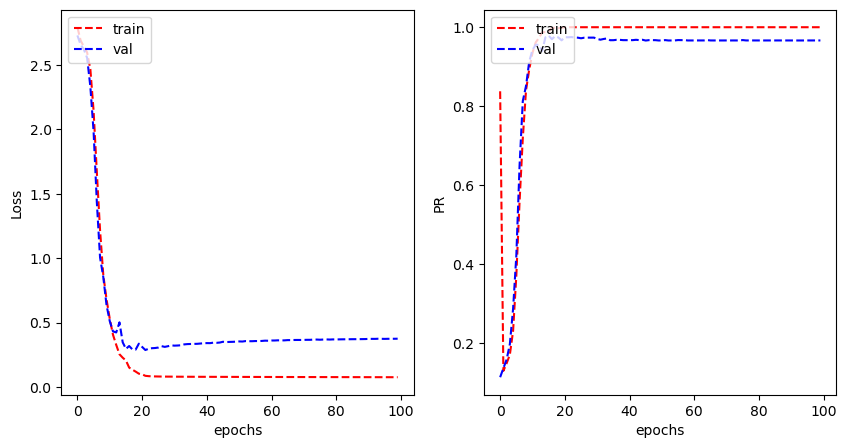

In [127]:
best_model_l2_type = tune_model(lambda_tuner, type_train_generator, type_val_generator, type_weights, 100, 'lambda', 16)

In [ ]:
best_model_l2_type.save('models/type/best_model_l2_type.keras')

Dropout Regularisation

Best dropout_rate: 0.4


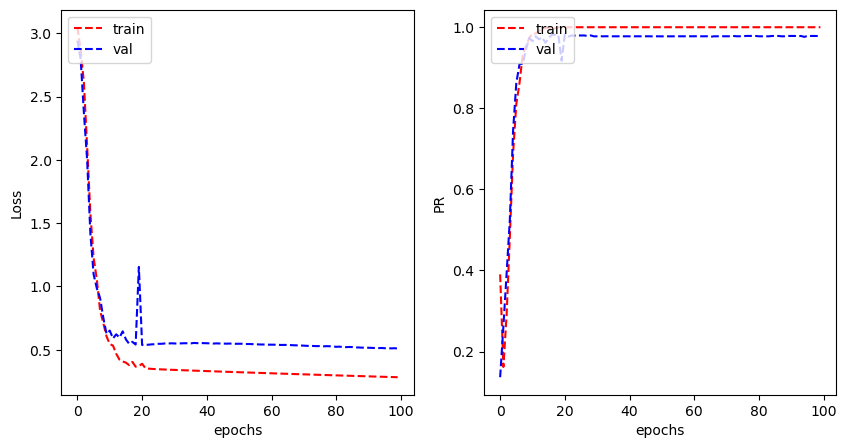

In [128]:
best_model_droput_type = tune_model(dropout_tuner, type_train_generator, type_val_generator, type_weights, 100, 'dropout_rate', 16)

In [ ]:
best_model_droput_type.save('models/type/best_model_droput_type.keras')

Augmented Data

/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_30"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_30 (Flatten)            │ (None, 2352)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_60 (Dense)                │ (None, 400)            │       941,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_61 (Dense)                │ (None, 16)             │         6,416 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 947,616 (3.61 MB)

 Trainable params: 947,616 (3.61 MB)

 Non-trainable params: 0 (0.00 B)

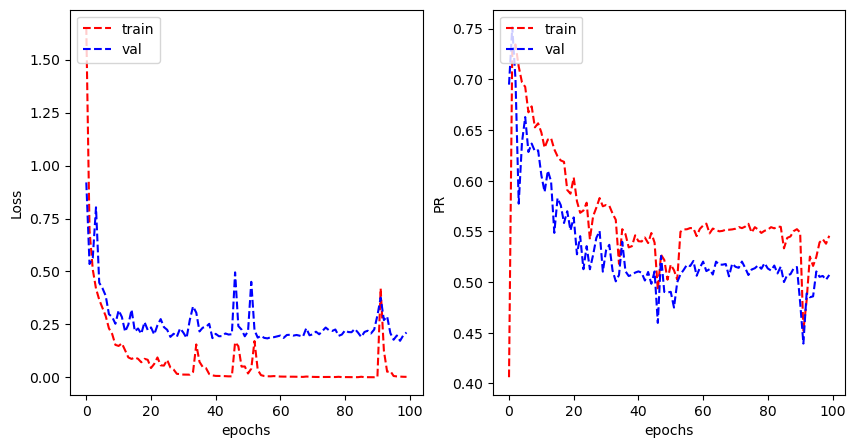

In [157]:
baseline_mlp_model_type_aug = pipeline(baseline_mlp(16),
                              type_train_generator, 
                              type_val_generator, 
                              metric_label='PR',
                              optimiser='adam',
                              activation='relu',
                              epoch=100,
                              class_weights=None)

In [158]:
baseline_mlp_model_type_aug.save('models/type/baseline_mlp_model_type_aug.keras')

/opt/anaconda3/lib/python3.11/site-packages/keras/src/backend/tensorflow/nn.py:585: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


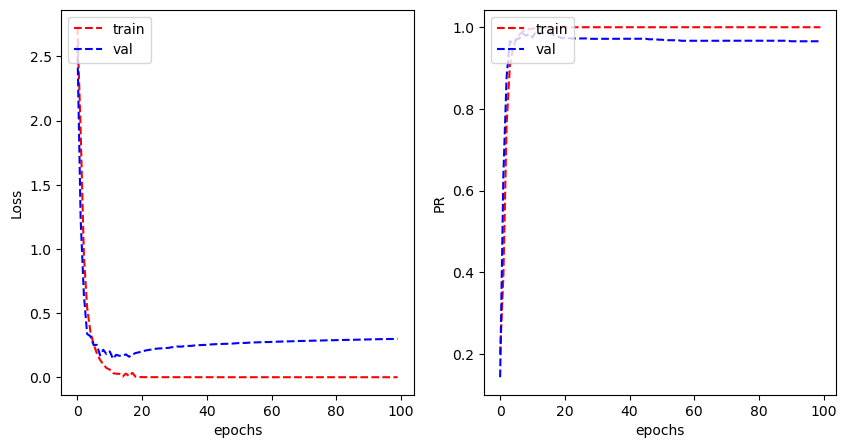

In [129]:
model_VGG_base_SGD_type_aug = pipeline(build_model_VGG(input_shape=INPUT_DIM,output_classes=16, activation='relu'),
                         type_aug_train_generator, 
                          type_val_generator, 
                          metric_label='PR',
                          optimiser='sgd',
                          activation='relu',
                          epoch=100,
                          class_weights=None)

In [131]:
model_VGG_base_SGD_type_aug.save('models/type/model_VGG_base_SGD_type_aug.keras')

L2 Regularisation

Best lambda: 0.0002182433505738606


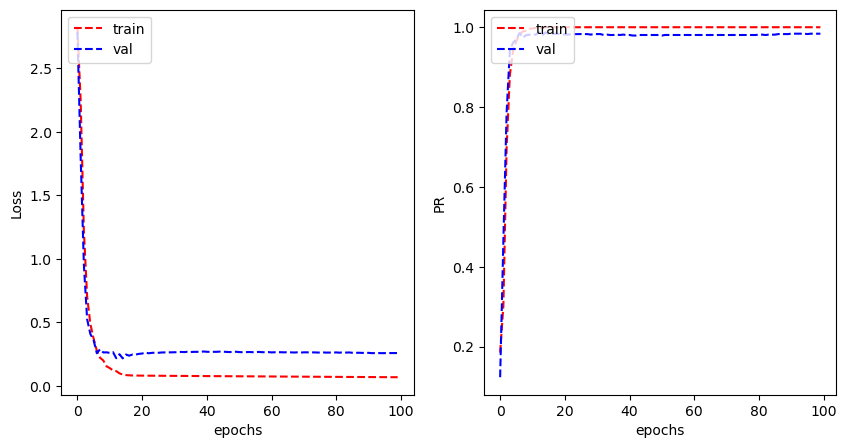

In [132]:
best_model_l2_type_aug = tune_model(lambda_tuner, type_aug_train_generator, type_val_generator, type_weights, 100, 'lambda', 16)

In [135]:
best_model_l2_type_aug.save('models/type/best_model_l2_type_aug.keras')

Dropout Regularisation

Best dropout_rate: 0.4


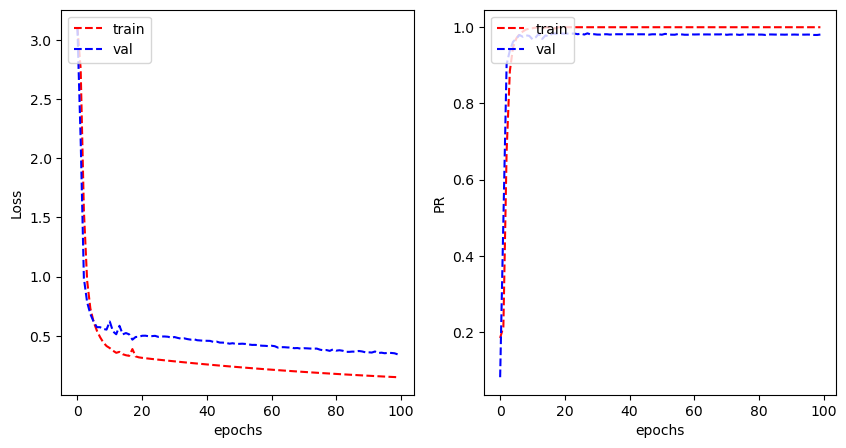

In [133]:
best_model_droput_type_aug = tune_model(dropout_tuner, type_aug_train_generator, type_val_generator, type_weights, 100, 'dropout_rate', 16)

In [134]:
best_model_droput_type_aug.save('models/type/best_model_droput_type_aug.keras')

### Testing

In [164]:
label_names = {'bicycle':0, 'continue':1, 'crossing':2, 'giveway':3, 'laneend':4, 'limitedtraffic':5,
'noentry': 6, 
'noparking': 7,
'parking': 8, 'rightofway': 9, 'roundabout': 10,'speed': 11, 'stop': 12, 'trafficdirective': 13, 'traveldirection': 14, 'warning': 15}

In [168]:
def plot_ground_truth (test_generator, model_name):
    d_inv = {v: k for k, v in label_names.items()}
    plt.figure(figsize=(16,4))
    batches = 0
    for x, y in test_generator:
        batches = batches + 1
        y_hat = model_name.predict(x, verbose=0)
        
        # Select a single image from the batch
        x_single = x[0]  # Assuming batch size is the first dimension
        
        # Reshape if needed (if your images are flattened)
        # x_single = x_single.reshape((height, width, channels))
        
        if batches < 5:
            plt.subplot(1, 5, batches)
            plt.imshow(x_single)
            plt.title("GT-{}, Pred-{}".format(d_inv[np.argmax(y[0])], d_inv[np.argmax(y_hat[0])] ))
            plt.axis('off')
        else:
            break

    plt.show()


In [169]:
def plot_incorrect_predictions(test_generator, model, num_display=5):
    d_inv = {v: k for k, v in label_names.items()}
    incorrect_predictions = []
    batches = 0
    for x, y in test_generator:
        batches += 1
        y_hat = model.predict(x, verbose=0)
        for i in range(len(x)):
            if np.argmax(y[i]) != np.argmax(y_hat[i]):
                incorrect_predictions.append((x[i], y[i], y_hat[i]))
        if len(incorrect_predictions) >= num_display:
            break
    
    plt.figure(figsize=(16, 4))
    for i, (x, y, y_hat) in enumerate(incorrect_predictions[:num_display]):
        plt.subplot(1, num_display, i+1)
        plt.imshow(x)
        plt.title("GT-{}, Pred-{}".format(d_inv[np.argmax(y)], d_inv[np.argmax(y_hat)]))
        plt.axis('off')
    
    plt.show()


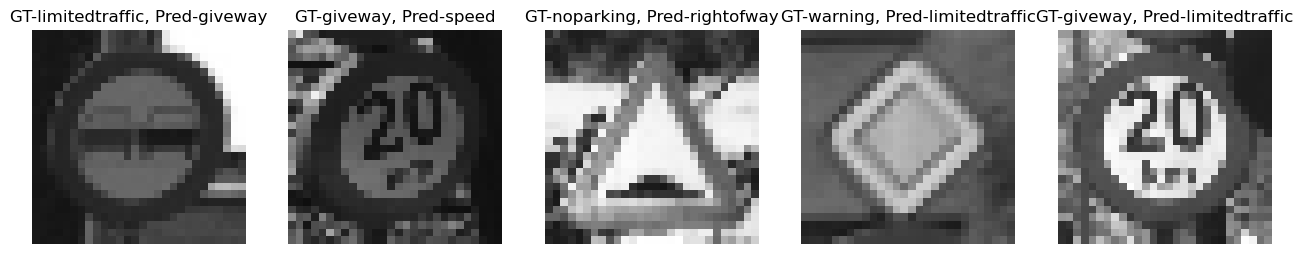

In [170]:
plot_incorrect_predictions(type_test_generator,best_model_droput_type_aug)

In [209]:
test_data_external = fetch_images('Dataset/evaluation/test_data_external')

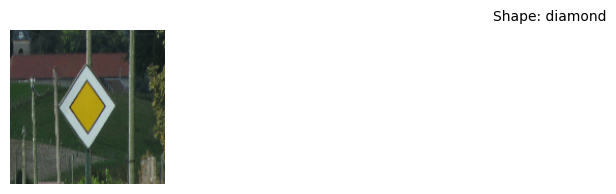

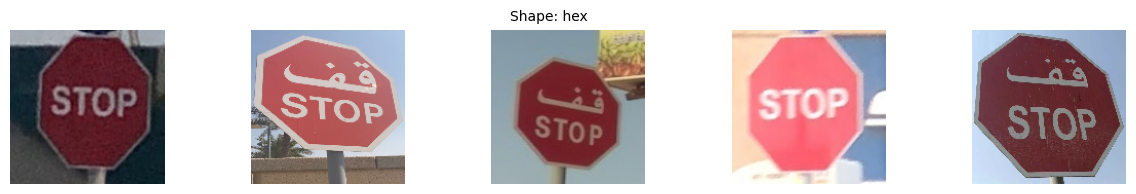

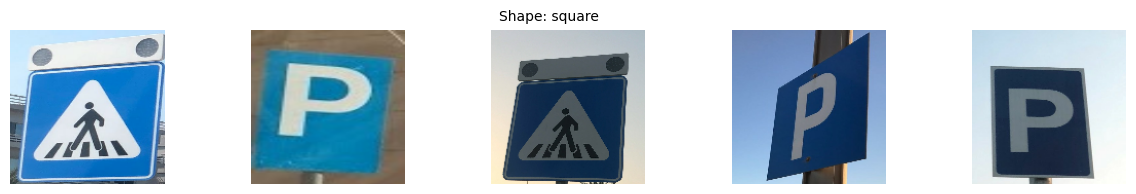

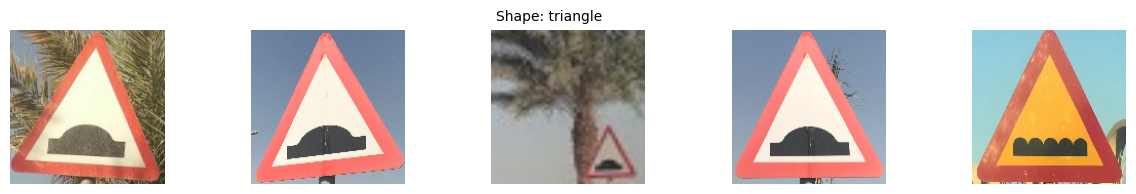

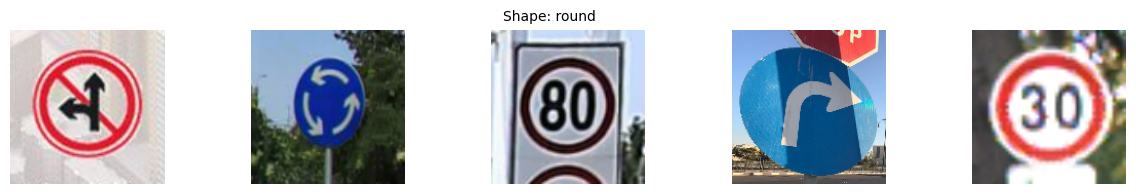

In [202]:
display_images(test_data_external, "Shape", 5)

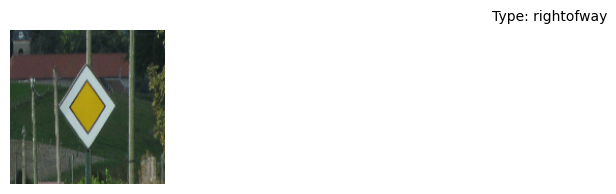

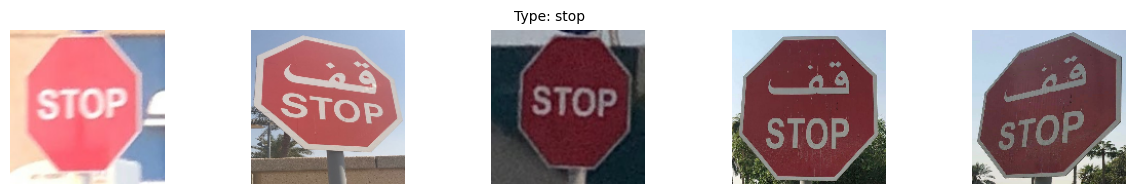

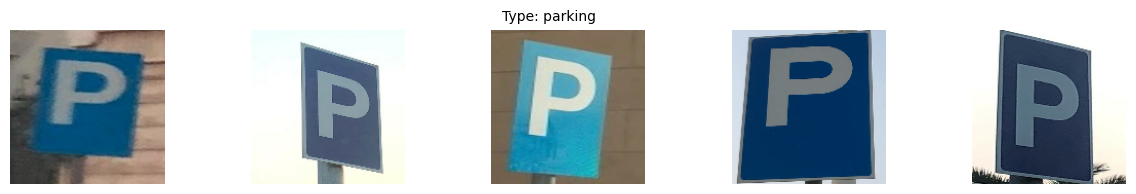

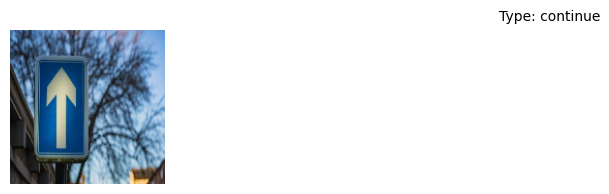

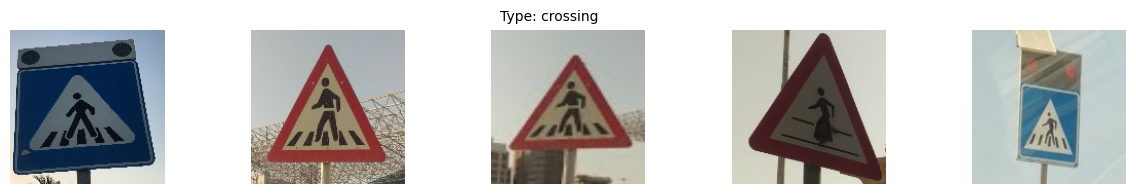

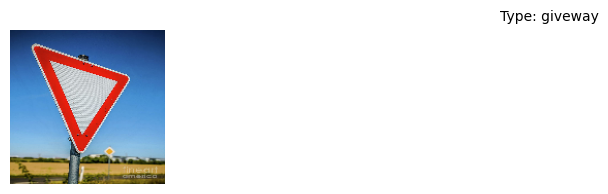

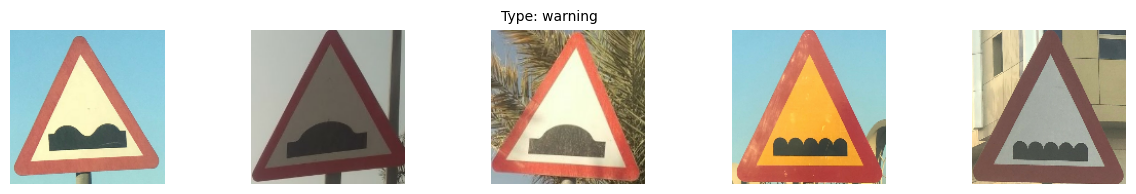

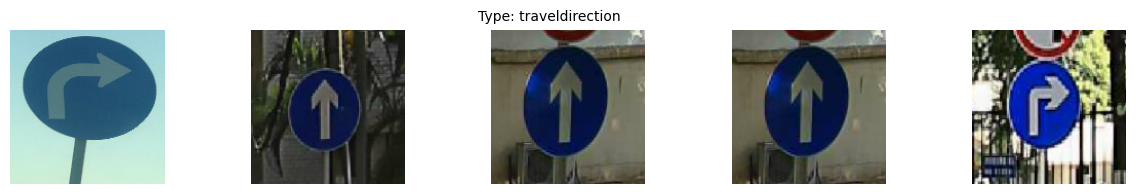

2024-05-19 13:47:25.421705: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: INVALID_ARGUMENT: Unknown image file format. One of JPEG, PNG, GIF, BMP required.


InvalidArgumentError: {{function_node __wrapped__DecodeImage_device_/job:localhost/replica:0/task:0/device:CPU:0}} Unknown image file format. One of JPEG, PNG, GIF, BMP required. [Op:DecodeImage] name: 

<Figure size 1500x200 with 0 Axes>

In [203]:
display_images(test_data_external, "Type", 5)

In [210]:
encoder(test_data_external)

                Type  Encoded_Value
0            bicycle              0
1           continue              1
2           crossing              2
3            giveway              3
4     limitedtraffic              4
5            noentry              5
6          noparking              6
7            parking              7
8         rightofway              8
9         roundabout              9
10             speed             10
11              stop             11
12  trafficdirective             12
13   traveldirection             13
14           warning             14


Path  Shape  Type
0    Dataset/evaluation/test_data_external/diamond/...      0     8
1    Dataset/evaluation/test_data_external/hex/stop...      1    11
2    Dataset/evaluation/test_data_external/hex/stop...      1    11
3    Dataset/evaluation/test_data_external/hex/stop...      1    11
4    Dataset/evaluation/test_data_external/hex/stop...      1    11
..                                                 ...    ...   ...
703  Dataset/evaluation/test_data_external/round/tr...      2    12
704  Dataset/evaluation/test_data_external/round/tr...      2    12
705  Dataset/evaluation/test_data_external/round/tr...      2    12
706  Dataset/evaluation/test_data_external/round/tr...      2    12
707  Dataset/evaluation/test_data_external/round/tr...      2    12

[708 rows x 3 columns]

In [215]:
test_data_external_shape_gen = create_image_batches(df=test_data_external, batch_size=32, label='Shape', target_size=(28, 28), is_train=True)
test_data_external_type_gen = create_image_batches(df=test_data_external, batch_size=32, label='Type', target_size=(28, 28), is_train=True)

Found 707 validated image filenames belonging to 5 classes.
Found 707 validated image filenames belonging to 14 classes.


/opt/anaconda3/lib/python3.11/site-packages/keras/src/legacy/preprocessing/image.py:920: UserWarning: Found 1 invalid image filename(s) in x_col="Path". These filename(s) will be ignored.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/keras/src/legacy/preprocessing/image.py:920: UserWarning: Found 1 invalid image filename(s) in x_col="Path". These filename(s) will be ignored.
  warnings.warn(


In [224]:
# Get the size of the images
image_size = test_data_external_shape_gen.image_shape
print("Image size:", image_size)

# Get the color mode
color_mode = test_data_external_shape_gen.color_mode
print("Color mode:", color_mode)


Image size: (28, 28, 1)
Color mode: grayscale


In [253]:
baseline_mlp_model_shape.evaluate(test_data_external_shape_gen)

23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 72ms/step - PR: 0.4835 - loss: 3.0778


[3.07743763923645, 0.4818357825279236]

In [ ]:
baseline_mlp_model_shape.evaluate(test_data_external_shape_gen)